# Comparison of colon subtype CNV-expression association with DRAGON

In this notebook we are reproducing the colon cancer subtype results of the "Reproducible processing of TCGA regulatory
networks" paper.

After generating CNV-expression DRAGON networks for CMS2 and CMS4 we proceed to analyze these
networks. We are interested in investigating whether complex multi-omics associations can explain the different
phenotypes of the four groups, and in particular the worse prognostics of CMS4.

First we are going to import some packages and define some functions. Go to section [Read the data](#read-the-data).

In [149]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns
import scipy.stats as stats
import gseapy as gp
import networkx as nx

# this is necessary only for better label positioning
!pip install adjustText

In [150]:
def get_long_dragon(dragons):
    """melt all dragons
    returns dataframe with melt dragons. 
    Pass a dictionary with dragons"""
    
    for k,key in enumerate(dragons.keys()):
        
        temp = dragons[key]
        # Step 1: Create a mask for the upper triangular matrix excluding the diagonal
        mask = np.triu(np.ones(temp.shape), k=1).astype(bool)

        # Step 2: Apply the mask to filter the DataFrame
        df_upper_tri = temp.where(mask)
        
        dragon = df_upper_tri.stack().reset_index()
        print(dragon)
        dragon.columns = ['node1', 'node2', key]
        print(dragon)
        if k==0:
            df = dragon
        else:
            df = df.merge(dragon, on=['node1', 'node2'], how = 'outer')
    return(df)

In [151]:
def read_pandas(panda_fn):
    """Read pandas dataframes"""
    panda_data = {}
    for key, datafn in panda_fn.items():
        print(key)
        panda_data[key] = pd.read_csv(datafn, sep = ' ', index_col = 0)
    return(panda_data)

def read_dragons(dragon_fn):
    """Read dragon dataframes"""
    dragon_data = {}
    for key, datafn in dragon_fn.items():
        print(key)
        dragon_data[key] = pd.read_csv(datafn, sep = '\t', index_col = 0)
    return(dragon_data)

def get_indegree(panda_data, th = 0.5):
    """Get indegree (gene degree) for PANDA dataframes"""
    df = pd.DataFrame()
    for key, datafn in panda_data.items():
        print(key)
        temp = pd.DataFrame((datafn*1*(datafn>th)).sum(axis = 0))
        temp = temp.rename(columns={0:key})
        df = df.merge(temp, left_index=True, right_index=True, how = 'outer').fillna(-1)
    return(df)
        
def get_outdegree(panda_data, th = 0.5):
    """Get outdegree (TF degree) for PANDA dataframes"""
    df = pd.DataFrame()
    for key, datafn in panda_data.items():
        print(key)
        temp = pd.DataFrame((datafn*1*(datafn>th)).sum(axis = 1))
        temp = temp.rename(columns={0:key})
        df = df.merge(temp, left_index=True, right_index=True, how = 'outer').fillna(-1)
    return(df)
        

## Read the data

First we need to specify the output folder and read the data

For this notebook you'll need:
- The gencode v26 gene mapping (needed to map gene names)
- The CMS2 and CMS4 CNV-expression DRAGON networks
- The preprocessed expression and CNV data

You'll find all these data inside the data folder, alongside the code.


Here specify the output folder and the input dragon matrices, dependending on where you saved them

In [152]:

# specify the output folder
output_folder = '../results/dragon-post-cnv/'
# Check if folder exists
if os.path.exists(output_folder):
    print('Folder exists')
else:
    os.mkdir(output_folder)

Folder exists


In [153]:
dragon_fn  = {
             'cms2': '../data/processed/batch-coad-subtype-20250406/tcga_coad_cms2/analysis/dragon/tcga_coad_cms2_cnv_expression_dragon_mat.tsv',
             'cms4': '../data/processed/batch-coad-subtype-20250406/tcga_coad_cms4/analysis/dragon/tcga_coad_cms4_cnv_expression_dragon_mat.tsv'}

In [154]:
# order of subtypes
subtype_order = ['cms2', 'cms4']

### Read the raw data


In [155]:
genemap_cms2 = pd.read_csv('/Users/violafanfani/Documents/uni-harvard/projects/tcga-coad-subtype/results/tcga_coad_cms2/data_download/cnv/cms2_gene_map.csv', index_col = 0)

In [156]:
genemap_cms2

gene_id    gene_name
ENSG00000223972.5                ENSG00000223972.5      DDX11L1
ENSG00000227232.5                ENSG00000227232.5       WASH7P
ENSG00000278267.1                ENSG00000278267.1    MIR6859-1
ENSG00000243485.5                ENSG00000243485.5  MIR1302-2HG
ENSG00000284332.1                ENSG00000284332.1    MIR1302-2
...                                            ...          ...
ENSG00000124334.17_PAR_Y  ENSG00000124334.17_PAR_Y         IL9R
ENSG00000270726.6_PAR_Y    ENSG00000270726.6_PAR_Y   AJ271736.1
ENSG00000185203.12_PAR_Y  ENSG00000185203.12_PAR_Y       WASIR1
ENSG00000182484.15_PAR_Y  ENSG00000182484.15_PAR_Y       WASH6P
ENSG00000227159.8_PAR_Y    ENSG00000227159.8_PAR_Y     DDX11L16

[60623 rows x 2 columns]

In [157]:
raw_cms2 = pd.read_csv('/Users/violafanfani/Documents/uni-harvard/projects/tcga-coad-subtype/results/tcga_coad_cms2/data_download/cnv/tcga_coad_cms2.csv', index_col = 0)
raw_cms4 = pd.read_csv('/Users/violafanfani/Documents/uni-harvard/projects/tcga-coad-subtype/results/tcga_coad_cms4/data_download/cnv/tcga_coad_cms4.csv', index_col = 0)
raw_cms4

TCGA-D5-5538-01A;TCGA-D5-5538-10A  \
ENSG00000223972.5                                       NaN   
ENSG00000227232.5                                       NaN   
ENSG00000278267.1                                       NaN   
ENSG00000243485.5                                       NaN   
ENSG00000284332.1                                       NaN   
...                                                     ...   
ENSG00000124334.17_PAR_Y                                NaN   
ENSG00000270726.6_PAR_Y                                 NaN   
ENSG00000185203.12_PAR_Y                                NaN   
ENSG00000182484.15_PAR_Y                                NaN   
ENSG00000227159.8_PAR_Y                                 NaN   

                          TCGA-D5-6922-01A;TCGA-D5-6922-10A  \
ENSG00000223972.5                                       NaN   
ENSG00000227232.5                                       NaN   
ENSG00000278267.1                                       NaN   
ENSG00000243485.5                                       NaN   
ENSG00000284332.1                                       NaN   
...                                                     ...   
ENSG00000124334.17_PAR_Y                                NaN   
ENSG00000270726.6_PAR_Y                                 NaN   
ENSG00000185203.12_PAR_Y                                NaN   
ENSG00000182484.15_PAR_Y                                NaN   
ENSG00000227159.8_PAR_Y                                 NaN   

                          TCGA-AZ-6605-11A;TCGA-AZ-6605-01A  \
ENSG00000223972.5                                       NaN   
ENSG00000227232.5                                       NaN   
ENSG00000278267.1                                       NaN   
ENSG00000243485.5                                       NaN   
ENSG00000284332.1                                       NaN   
...                                                     ...   
ENSG00000124334.17_PAR_Y                                NaN   
ENSG00000270726.6_PAR_Y                                 NaN   
ENSG00000185203.12_PAR_Y                                NaN   
ENSG00000182484.15_PAR_Y                                NaN   
ENSG00000227159.8_PAR_Y                                 NaN   

                          TCGA-D5-6924-01A;TCGA-D5-6924-10A  \
ENSG00000223972.5                                       NaN   
ENSG00000227232.5                                       NaN   
ENSG00000278267.1                                       NaN   
ENSG00000243485.5                                       NaN   
ENSG00000284332.1                                       NaN   
...                                                     ...   
ENSG00000124334.17_PAR_Y                                NaN   
ENSG00000270726.6_PAR_Y                                 NaN   
ENSG00000185203.12_PAR_Y                                NaN   
ENSG00000182484.15_PAR_Y                                NaN   
ENSG00000227159.8_PAR_Y                                 NaN   

                          TCGA-CM-5860-01A;TCGA-CM-5860-10A  \
ENSG00000223972.5                                       NaN   
ENSG00000227232.5                                       NaN   
ENSG00000278267.1                                       NaN   
ENSG00000243485.5                                       NaN   
ENSG00000284332.1                                       NaN   
...                                                     ...   
ENSG00000124334.17_PAR_Y                                NaN   
ENSG00000270726.6_PAR_Y                                 NaN   
ENSG00000185203.12_PAR_Y                                NaN   
ENSG00000182484.15_PAR_Y                                NaN   
ENSG00000227159.8_PAR_Y                                 NaN   

                          TCGA-D5-6529-01A;TCGA-D5-6529-10A  \
ENSG00000223972.5                                       NaN   
ENSG00000227232.5                                       NaN   
ENSG00000278267.1                                   

In [158]:
raw_cms2.index = raw_cms2.index.map(genemap_cms2['gene_name'])
raw_cms4.index = raw_cms4.index.map(genemap_cms2['gene_name'])

In [159]:
def get_raw_table_from_dragon(dragon_df, raw_df):
    df_cols = pd.DataFrame(data = raw_df.columns, columns = ['raw_name'])
    df_cols['raw1'] = df_cols['raw_name'].str.split(';').str[0]
    df_cols['raw2'] = df_cols['raw_name'].str.split(';').str[1]
    print(df_cols)
    dragon_cols = dragon_df.index.tolist()
    print(dragon_cols)
    df_cols['match_raw1'] = [1+dragon_cols.index(i) if i in dragon_cols else 0 for i in df_cols['raw1']]
    df_cols['match_raw2'] = [1+dragon_cols.index(i) if i in dragon_cols else 0 for i in df_cols['raw2']]
    df_cols['dragon_cols_index'] = df_cols.match_raw1 + df_cols.match_raw2
    df_cols['dragon_cols_index'] = df_cols['dragon_cols_index'].replace(0, np.nan)
    df_cols['dragon_cols_index'] = df_cols['dragon_cols_index'].astype('Int64')-1
    df_cols['dragon_cols'] = [dragon_cols[i] for i in df_cols['dragon_cols_index']]
    df_cols = df_cols.dropna(subset = 'dragon_cols_index')
    new_cms = raw_df.T
    dragon_genes = [i.split('_')[0].replace('.','-') if ( ('.' in i) & ((not i.startswith('AC'))&(not i.startswith('ZNF8')))) else i.split('_')[0] for i in dragon_df.columns.tolist() if i.endswith('_cnv')]
    print(dragon_genes)
    new_cms = new_cms.loc[:,dragon_genes]
    new_cms['barcode'] = new_cms.index.map(df_cols.loc[:,['raw_name','dragon_cols']].set_index('raw_name')['dragon_cols'])
    
    return(df_cols, new_cms)

### Starting to read the data

In [160]:
# read the dragons
dragons = read_dragons(dragon_fn)

cms2
cms4


In [161]:
# we need to make sure the dragons are symmetric and that nothing went wrong
assert np.isclose(dragons['cms2'].values,dragons['cms2'].T.values).all()
assert np.isclose(dragons['cms4'].values,dragons['cms4'].T.values).all()

In [162]:
# get long dragons
dragon = get_long_dragon(dragons)

                   level_0            level_1         0
0                  SKI_cnv           HES5_cnv  0.121488
1                  SKI_cnv         PRDM16_cnv  0.090598
2                  SKI_cnv           TP73_cnv  0.087525
3                  SKI_cnv           HES3_cnv  0.060668
4                  SKI_cnv           HES2_cnv  0.060668
...                    ...                ...       ...
4131370  ZNF449_expression  ZNF275_expression  0.006445
4131371  ZNF449_expression   MECP2_expression  0.006525
4131372   HSFX2_expression  ZNF275_expression  0.006698
4131373   HSFX2_expression   MECP2_expression  0.006647
4131374  ZNF275_expression   MECP2_expression  0.010248

[4131375 rows x 3 columns]
                     node1              node2      cms2
0                  SKI_cnv           HES5_cnv  0.121488
1                  SKI_cnv         PRDM16_cnv  0.090598
2                  SKI_cnv           TP73_cnv  0.087525
3                  SKI_cnv           HES3_cnv  0.060668
4                  S

In [163]:
print(dragon.shape)
dragon.head()
# Dragons have 1067100 edges in total (we only consider the upper triangular matrix and we merge on the edge name)

(4258425, 4)


node1             node2      cms2      cms4
0  AC008770.3_cnv  ADNP2_expression -0.000867  0.001317
1  AC008770.3_cnv          ADNP_cnv  0.000643  0.000043
2  AC008770.3_cnv   ADNP_expression  0.000369 -0.000656
3  AC008770.3_cnv  AEBP1_expression  0.000287 -0.001124
4  AC008770.3_cnv  AEBP2_expression -0.001812 -0.000214

We add some columns with the node names and average/variance of edges

In [164]:
# mean dragon value for all subtypes
dragon['mean']  = dragon.loc[:,subtype_order].mean(axis =1)
# absolute mean dragon value for all subtypes
dragon['abs_mean']  = np.abs(dragon.loc[:,subtype_order]).mean(axis =1)
# variance
dragon['var']  = dragon.loc[:,subtype_order].var(axis =1)

# node type, whether expression or methylation
dragon['node1_type'] = [i.split('_')[1] for i in dragon['node1']]
dragon['node2_type'] = [i.split('_')[1] for i in dragon['node2']]
# node name
dragon['node1_tf'] = [i.split('_')[0] for i in dragon['node1']]
dragon['node2_tf'] = [i.split('_')[0] for i in dragon['node2']]

# get absolute values for dragons
dragon.loc[:,[i+'_abs' for i in subtype_order]] = np.abs(dragon.loc[:,subtype_order].values)

# edge name
dragon['edge'] = dragon.node1_tf +'-'+ dragon.node2_tf
dragon = dragon.set_index('edge')
# select same TF edges
dragon['same'] = 1*(dragon.node1_tf == dragon.node2_tf)
dragon.sort_values(by = 'mean', ascending = False)

node1       node2      cms2      cms4      mean  abs_mean  \
edge                                                                            
ZNF703-BRF2    ZNF703_cnv    BRF2_cnv  0.311409  0.196041  0.253725  0.253725   
NKX6.3-THAP1   NKX6.3_cnv   THAP1_cnv  0.308407  0.112449  0.210428  0.210428   
SHOX-ZBED1       SHOX_cnv   ZBED1_cnv  0.241487  0.162461  0.201974  0.201974   
NKX2.4-NKX2.2  NKX2.4_cnv  NKX2.2_cnv  0.150555       NaN  0.150555  0.150555   
NKX2.4-PAX1    NKX2.4_cnv    PAX1_cnv  0.144618       NaN  0.144618  0.144618   
...                   ...         ...       ...       ...       ...       ...   
TFCP2-GSC2      TFCP2_cnv    GSC2_cnv -0.072384  0.000265 -0.036059  0.036325   
POU6F1-GSC2    POU6F1_cnv    GSC2_cnv -0.072384  0.000265 -0.036059  0.036325   
ATF1-GSC2        ATF1_cnv    GSC2_cnv -0.072384  0.000265 -0.036059  0.036325   
MEF2C-FOXS1     MEF2C_cnv   FOXS1_cnv -0.089593  0.001881 -0.043856  0.045737   
LHX9-FOXS1       LHX9_cnv   FOXS1_cnv -0.094032  0.002309 -0.045861  0.048171   

                    var node1_type node2_type node1_tf node2_tf  cms2_abs  \
edge                                                                        
ZNF703-BRF2    0.006655        cnv        cnv   ZNF703     BRF2  0.311409   
NKX6.3-THAP1   0.019200        cnv        cnv   NKX6.3    THAP1  0.308407   
SHOX-ZBED1     0.003123        cnv        cnv     SHOX    ZBED1  0.241487   
NKX2.4-NKX2.2       NaN        cnv        cnv   NKX2.4   NKX2.2  0.150555   
NKX2.4-PAX1         NaN        cnv        cnv   NKX2.4     PAX1  0.144618   
...                 ...        ...        ...      ...      ...       ...   
TFCP2-GSC2     0.002639        cnv        cnv    TFCP2     GSC2  0.072384   
POU6F1-GSC2    0.002639        cnv        cnv   POU6F1     GSC2  0.072384   
ATF1-GSC2      0.002639        cnv        cnv     ATF1     GSC2  0.072384   
MEF2C-FOXS1    0.004184        cnv        cnv    MEF2C    FOXS1  0.089593   
LHX9-FOXS1     0.004641        cnv        cnv     LHX9    FOXS1  0.094032   

               cms4_abs  same  
edge                           
ZNF703-BRF2    0.196041     0  
NKX6.3-THAP1   0.112449     0  
SHOX-ZBED1     0.162461     0  
NKX2.4-NKX2.2       NaN     0  
NKX2.4-PAX1         NaN     0  
...                 ...   ...  
TFCP2-GSC2     0.000265     0  
POU6F1-GSC2    0.000265     0  
ATF1-GSC2      0.000265     0  
MEF2C-FOXS1    0.001881     0  
LHX9-FOXS1     0.002309     0  

[4258425 rows x 14 columns]

In [165]:
# dragon means by edge type
dragon.groupby(by = ['node1_type', 'node2_type']).agg({i:'mean' for i in subtype_order})

cms2      cms4
node1_type node2_type                    
cnv        cnv         0.000615  0.000615
           expression -0.000002 -0.000002
expression expression  0.000354  0.000345

In [166]:
# absolute values
subtype_abs = [i+'_abs' for i in subtype_order]
dragon.groupby(by = ['node1_type', 'node2_type']).agg({i:'mean' for i in subtype_abs})

cms2_abs  cms4_abs
node1_type node2_type                    
cnv        cnv         0.002606  0.002436
           expression  0.001731  0.001484
expression expression  0.002037  0.001987

## General exploration

In [167]:
dragons['cms2']

SKI_cnv  HES5_cnv  PRDM16_cnv  TP73_cnv  HES3_cnv  \
SKI_cnv            0.000000  0.121488    0.090598  0.087525  0.060668   
HES5_cnv           0.121488  0.000000    0.093466  0.090317  0.058328   
PRDM16_cnv         0.090598  0.093466    0.000000  0.110448  0.074525   
TP73_cnv           0.087525  0.090317    0.110448  0.000000  0.074279   
HES3_cnv           0.060668  0.058328    0.074525  0.074279  0.000000   
...                     ...       ...         ...       ...       ...   
ZNF75D_expression  0.005999  0.006147    0.001931  0.001910 -0.001397   
ZNF449_expression  0.003462  0.002203    0.005258  0.005360  0.003936   
HSFX2_expression   0.007716  0.008722    0.004962  0.006219  0.002517   
ZNF275_expression  0.005655  0.005405   -0.000959 -0.001278 -0.001981   
MECP2_expression   0.005128  0.004386    0.001243  0.000442 -0.000854   

                   HES2_cnv  ZBTB48_cnv  THAP3_cnv  CAMTA1_cnv  CENPS_cnv  \
SKI_cnv            0.060668    0.060668   0.038452    0.042026  -0.003970   
HES5_cnv           0.058328    0.058328   0.040487    0.044733  -0.005560   
PRDM16_cnv         0.074525    0.074525   0.048196    0.052887   0.016089   
TP73_cnv           0.074279    0.074279   0.048680    0.053503   0.016945   
HES3_cnv           0.104218    0.104218   0.057470    0.061176   0.020651   
...                     ...         ...        ...         ...        ...   
ZNF75D_expression -0.001397   -0.001397  -0.001012    0.000815  -0.003833   
ZNF449_expression  0.003936    0.003936   0.003086    0.003986  -0.001174   
HSFX2_expression   0.002517    0.002517   0.004117    0.003175  -0.000784   
ZNF275_expression -0.001981   -0.001981   0.001011    0.001933  -0.000666   
MECP2_expression  -0.000854   -0.000854   0.001028    0.001682  -0.000574   

                   ...  ZMAT1_expression  NKRF_expression  ZBTB33_expression  \
SKI_cnv            ...          0.002918         0.006346           0.003521   
HES5_cnv           ...          0.002119         0.005240           0.004620   
PRDM16_cnv         ...          0.001217         0.000655           0.000489   
TP73_cnv           ...          0.001780         0.000565          -0.000289   
HES3_cnv           ...         -0.006876         0.000511          -0.002677   
...                ...               ...              ...                ...   
ZNF75D_expression  ...          0.007560         0.011807           0.009348   
ZNF449_expression  ...          0.009108         0.008235           0.008320   
HSFX2_expression   ...          0.003239         0.004698           0.002855   
ZNF275_expression  ...          0.006877         0.009710           0.008764   
MECP2_expression   ...          0.007423         0.008364           0.008501   

                   ELF4_expression  ZNF280C_expression  ZNF75D_expression  \
SKI_cnv                   0.005611            0.006613           0.005999   
HES5_cnv                  0.004766            0.007022           0.006147   
PRDM16_cnv               -0.001649            0.001863           0.001931   
TP73_cnv                 -0.001510            0.002443           0.001910   
HES3_cnv                 -0.002369           -0.001003          -0.001397   
...                            ...                 ...                ...   
ZNF75D_expression         0.009561            0.007942           0.000000   
ZNF449_expression         0.002023            0.006965           0.008262   
HSFX2_expression          0.004577            0.005837           0.006726   
ZNF275_expression         0.008636            0.006651           0.010385   
MECP2_expression          0.007875            0.007037           0.009092   

                   ZNF449_expression  HSFX2_expression  ZNF275_expression  \
SKI_cnv                     0.003462          0.007716           0.005655   
HES5_cnv                    0.002203          0.008722           0.005405   
PRDM16_cnv                  0.005258          0.004962          -0.000959   
TP73_cnv                

In [168]:
# check how many cnv nodes
n_cnvs = np.array([i.endswith('cnv') for i in dragons['cms2'].columns]).sum()
# check how many expression nodes
n_expression = np.array([i.endswith('expression') for i in dragons['cms2'].columns]).sum()

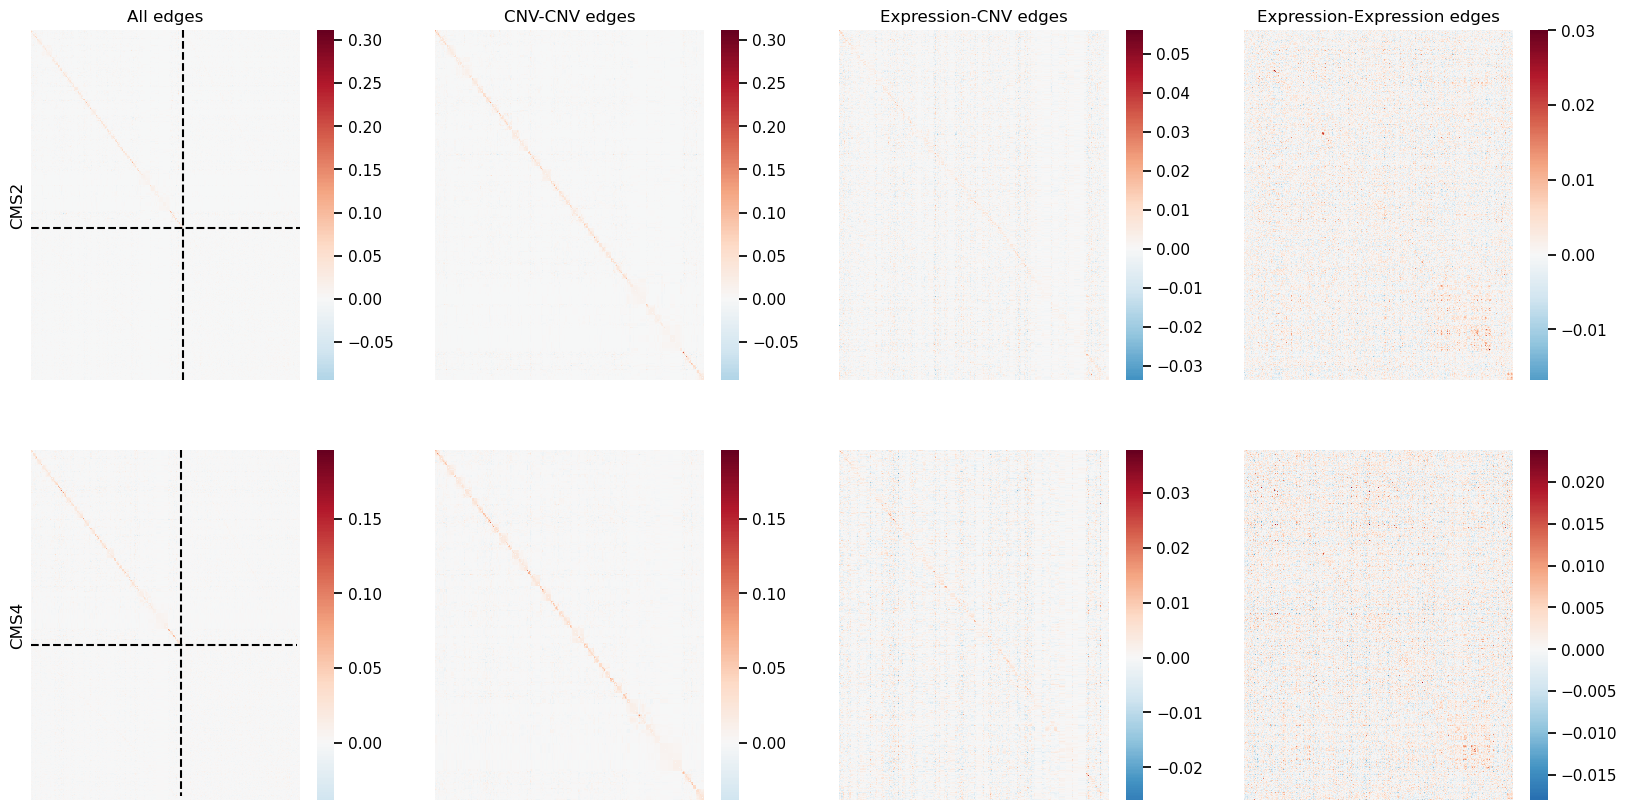

In [169]:
f, ax = plt.subplots(2, 4, figsize = (20, 10))
sns.heatmap(dragons['cms2'].values, cmap = 'RdBu_r', center = 0, xticklabels=False, yticklabels=False, ax = ax[0][0])
ax[0][0].hlines(y = n_cnvs, xmin = 0, xmax = n_cnvs + n_expression, color = 'black', linestyle = '--')
ax[0][0].vlines(x = n_cnvs, ymin = 0, ymax = n_cnvs + n_expression, color = 'black', linestyle = '--')

sns.heatmap(dragons['cms4'].values, cmap = 'RdBu_r', center = 0, xticklabels=False, yticklabels=False, ax = ax[1][0])
ax[1][0].hlines(y = n_cnvs, xmin = 0, xmax = n_cnvs + n_expression, color = 'black', linestyle = '--')
ax[1][0].vlines(x = n_cnvs, ymin = 0, ymax = n_cnvs + n_expression, color = 'black', linestyle = '--')

sns.heatmap(dragons['cms2'].iloc[:n_cnvs,:n_cnvs].values, cmap = 'RdBu_r', center = 0, xticklabels=False, yticklabels=False, ax = ax[0][1])
sns.heatmap(dragons['cms4'].iloc[:n_cnvs,:n_cnvs].values, cmap = 'RdBu_r', center = 0, xticklabels=False, yticklabels=False, ax = ax[1][1])


sns.heatmap(dragons['cms2'].iloc[n_cnvs:,:n_cnvs].values, cmap = 'RdBu_r', center = 0, xticklabels=False, yticklabels=False, ax = ax[0][2])
sns.heatmap(dragons['cms4'].iloc[n_cnvs:,:n_cnvs].values, cmap = 'RdBu_r', center = 0, xticklabels=False, yticklabels=False, ax = ax[1][2])

sns.heatmap(dragons['cms2'].iloc[n_cnvs:,n_cnvs:].values, cmap = 'RdBu_r', center = 0, xticklabels=False, yticklabels=False, ax = ax[0][3])
sns.heatmap(dragons['cms4'].iloc[n_cnvs:,n_cnvs:].values, cmap = 'RdBu_r', center = 0, xticklabels=False, yticklabels=False, ax = ax[1][3])

ax[0][0].set_ylabel('CMS2')
ax[1][0].set_ylabel('CMS4')
ax[0][0].set_title('All edges')
ax[0][1].set_title('CNV-CNV edges')
ax[0][2].set_title('Expression-CNV edges')
ax[0][3].set_title('Expression-Expression edges')
#f.savefig(os.path.join(output_folder, 'cms2-cms4-cnv-dragons.pdf'))
f.savefig(os.path.join(output_folder, 'cms2-cms4-cnv-dragons.png'), dpi = 300)

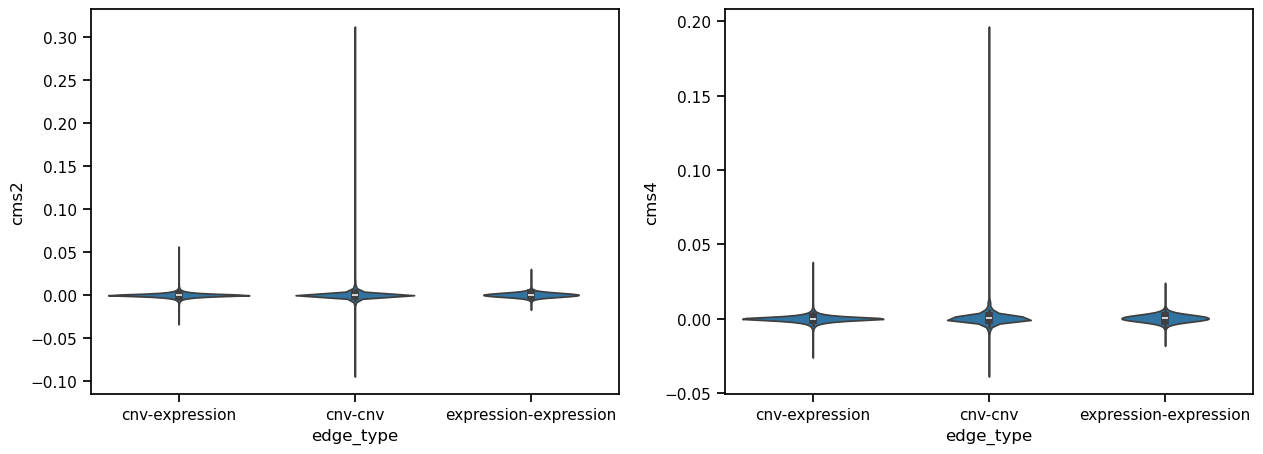

In [170]:
dragon['edge_type'] = dragon.node1_type +'-'+ dragon.node2_type
f, ax = plt.subplots(1,2, figsize = (15,5))
sns.violinplot(data = dragon.reset_index(), y = 'cms2', x = 'edge_type', ax = ax[0])
sns.violinplot(data = dragon.reset_index(), y = 'cms4', x = 'edge_type', ax = ax[1])
f.savefig(os.path.join(output_folder, 'cms2-cms4-edge-distribution.pdf'), dpi = 300)

#### Structural effects of CNV on edge weights

CNV usually involve deletions of duplications of DNA segments. For this reason, CNVs  of genes are dependent on the gene's
location on the genome. This effect is also visible also in our networks, that end up having blocks of similar edges.

In [171]:
# We annotate the edges to the DNA location
gencode = pd.read_csv('../data/external/gen_v26_mapping.csv', index_col = 0)
gencode

seqid   source   start     end strand            gene_id  \
1            chr1   HAVANA   11869   14409      +  ENSG00000223972.5   
2            chr1   HAVANA   14404   29570      -  ENSG00000227232.5   
3            chr1  ENSEMBL   17369   17436      -  ENSG00000278267.1   
4            chr1   HAVANA   29554   31109      +  ENSG00000243485.5   
5            chr1  ENSEMBL   30366   30503      +  ENSG00000284332.1   
...           ...      ...     ...     ...    ...                ...   
63852  KI270734.1  ENSEMBL   72411   74814      +  ENSG00000276017.1   
63853  KI270734.1  ENSEMBL  131494  137392      +  ENSG00000278817.1   
63854  KI270734.1  ENSEMBL  138082  161852      -  ENSG00000277196.4   
63855  KI270744.1  ENSEMBL   51009   51114      -  ENSG00000278625.1   
63856  KI270750.1  ENSEMBL  148668  148843      +  ENSG00000277374.1   

         gene_name                           gene_type  
1          DDX11L1  transcribed_unprocessed_pseudogene  
2           WASH7P              unprocessed_pseudogene  
3        MIR6859-1                               miRNA  
4      MIR1302-2HG                             lincRNA  
5        MIR1302-2                               miRNA  
...            ...                                 ...  
63852   AC007325.1                      protein_coding  
63853   AC007325.4                      protein_coding  
63854   AC007325.2                      protein_coding  
63855           U6                               snRNA  
63856           U1                               snRNA  

[63856 rows x 8 columns]

In [172]:
df_cols = pd.DataFrame(dragons['cms2'].columns)
df_cols.columns = ['col_name']
df_cols['tf'] = df_cols['col_name'].str.split('_').str[0]
df_cols = df_cols.merge(gencode, left_on = 'tf', right_on = 'gene_name', how = 'left')

In [173]:
chr1_cols = df_cols[(df_cols['col_name'].str.endswith('_cnv'))&(df_cols['seqid']=='chr1')].sort_values(by = 'start')
chr22_cols = df_cols[(df_cols['col_name'].str.endswith('_cnv'))&(df_cols['seqid']=='chr4')].sort_values(by = 'start')

chr1_cols

col_name      tf seqid  source        start          end strand  \
0       SKI_cnv     SKI  chr1  HAVANA    2228695.0    2310119.0      +   
1      HES5_cnv    HES5  chr1  HAVANA    2528745.0    2530245.0      -   
3    PRDM16_cnv  PRDM16  chr1  HAVANA    3069168.0    3438621.0      +   
4      TP73_cnv    TP73  chr1  HAVANA    3652520.0    3736201.0      +   
5      HES3_cnv    HES3  chr1  HAVANA    6244192.0    6245578.0      +   
..          ...     ...   ...     ...          ...          ...    ...   
127  ZNF669_cnv  ZNF669  chr1  HAVANA  247099962.0  247104372.0      -   
128  ZNF124_cnv  ZNF124  chr1  HAVANA  247121975.0  247172016.0      -   
129  ZNF496_cnv  ZNF496  chr1  HAVANA  247297412.0  247331846.0      -   
130  ZNF672_cnv  ZNF672  chr1  HAVANA  248838210.0  248849517.0      +   
131  ZNF692_cnv  ZNF692  chr1  HAVANA  248850006.0  248859144.0      -   

                gene_id gene_name       gene_type  
0     ENSG00000157933.9       SKI  protein_coding  
1     ENSG00000197921.5      HES5  protein_coding  
3    ENSG00000142611.16    PRDM16  protein_coding  
4    ENSG00000078900.14      TP73  protein_coding  
5     ENSG00000173673.7      HES3  protein_coding  
..                  ...       ...             ...  
127  ENSG00000188295.14    ZNF669  protein_coding  
128  ENSG00000196418.12    ZNF124  protein_coding  
129  ENSG00000162714.12    ZNF496  protein_coding  
130  ENSG00000171161.12    ZNF672  protein_coding  
131  ENSG00000171163.15    ZNF692  protein_coding  

[127 rows x 10 columns]

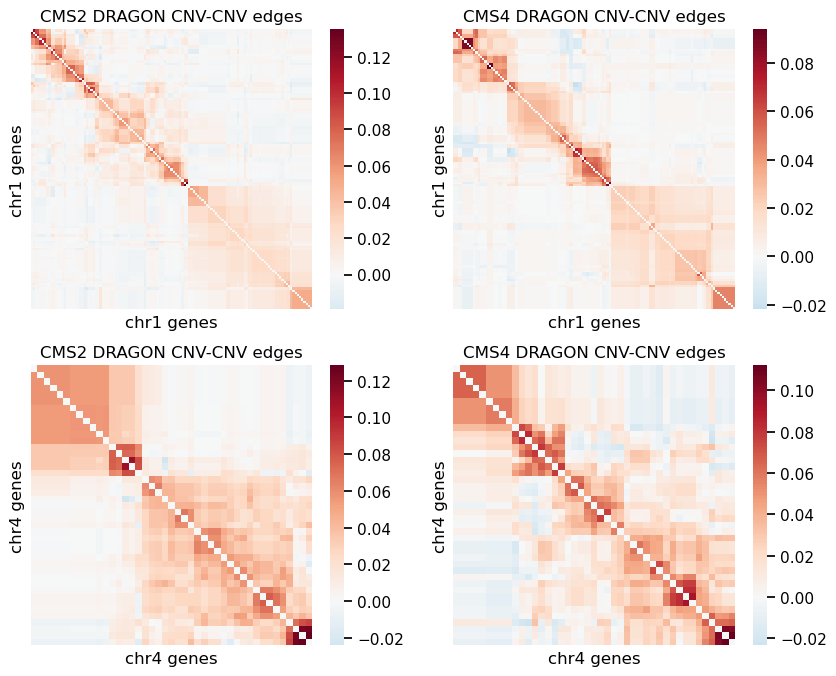

In [174]:
f, ax = plt.subplots(2, 2, figsize = (10, 8),)
sns.set_context('notebook', font_scale = 1)
sns.heatmap(dragons['cms2'].loc[chr1_cols.col_name, chr1_cols.col_name].values, cmap = 'RdBu_r', center = 0, ax = ax[0][0], xticklabels=False, yticklabels=False)
sns.heatmap(dragons['cms4'].loc[chr1_cols.col_name, chr1_cols.col_name].values, cmap = 'RdBu_r', center = 0, ax = ax[0][1], xticklabels=False, yticklabels=False)

sns.heatmap(dragons['cms2'].loc[chr22_cols.col_name, chr22_cols.col_name].values, cmap = 'RdBu_r', center = 0, ax = ax[1][0], xticklabels=False, yticklabels=False)
sns.heatmap(dragons['cms4'].loc[chr22_cols.col_name, chr22_cols.col_name].values, cmap = 'RdBu_r', center = 0, ax = ax[1][1], xticklabels=False, yticklabels=False)

ax[0][0].set_title('CMS2 DRAGON CNV-CNV edges')
ax[0][1].set_title('CMS4 DRAGON CNV-CNV edges')
ax[1][0].set_title('CMS2 DRAGON CNV-CNV edges')
ax[1][1].set_title('CMS4 DRAGON CNV-CNV edges')

fs = 12
ax[0][0].set_xlabel('chr1 genes', fontsize = fs)
ax[0][0].set_ylabel('chr1 genes', fontsize = fs)
ax[0][1].set_xlabel('chr1 genes', fontsize = fs)
ax[0][1].set_ylabel('chr1 genes', fontsize = fs)

ax[1][0].set_xlabel('chr4 genes')
ax[1][0].set_ylabel('chr4 genes')
ax[1][1].set_xlabel('chr4 genes')
ax[1][1].set_ylabel('chr4 genes')

f.savefig(os.path.join(output_folder, 'cms2-cms4-blocks.png'), dpi = 300)

### Correlation between CNV and expression on the same TF

First we plot the histograms of the edges, comparing those for the same TF to those of different TFs 

In [175]:
# Get only CNV to expression edges
dragon_trans = dragon[(dragon.node1_type!=dragon.node2_type)]
dragon_trans.head()

node1              node2      cms2      cms4  \
edge                                                                       
AC008770.3-ADNP2   AC008770.3_cnv   ADNP2_expression -0.000867  0.001317   
AC008770.3-ADNP    AC008770.3_cnv    ADNP_expression  0.000369 -0.000656   
AC008770.3-AEBP1   AC008770.3_cnv   AEBP1_expression  0.000287 -0.001124   
AC008770.3-AEBP2   AC008770.3_cnv   AEBP2_expression -0.001812 -0.000214   
AC008770.3-AHCTF1  AC008770.3_cnv  AHCTF1_expression -0.000704  0.000619   

                       mean  abs_mean           var node1_type  node2_type  \
edge                                                                         
AC008770.3-ADNP2   0.000225  0.001092  2.385443e-06        cnv  expression   
AC008770.3-ADNP   -0.000143  0.000513  5.257575e-07        cnv  expression   
AC008770.3-AEBP1  -0.000419  0.000705  9.952867e-07        cnv  expression   
AC008770.3-AEBP2  -0.001013  0.001013  1.275843e-06        cnv  expression   
AC008770.3-AHCTF1 -0.000043  0.000662  8.756109e-07        cnv  expression   

                     node1_tf node2_tf  cms2_abs  cms4_abs  same  \
edge                                                               
AC008770.3-ADNP2   AC008770.3    ADNP2  0.000867  0.001317     0   
AC008770.3-ADNP    AC008770.3     ADNP  0.000369  0.000656     0   
AC008770.3-AEBP1   AC008770.3    AEBP1  0.000287  0.001124     0   
AC008770.3-AEBP2   AC008770.3    AEBP2  0.001812  0.000214     0   
AC008770.3-AHCTF1  AC008770.3   AHCTF1  0.000704  0.000619     0   

                        edge_type  
edge                               
AC008770.3-ADNP2   cnv-expression  
AC008770.3-ADNP    cnv-expression  
AC008770.3-AEBP1   cnv-expression  
AC008770.3-AEBP2   cnv-expression  
AC008770.3-AHCTF1  cnv-expression

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/4158463479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans['same TF'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)


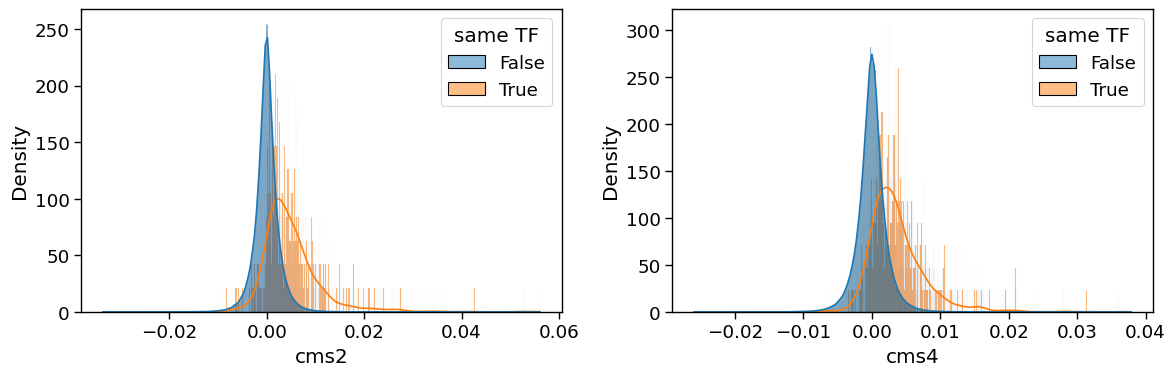

In [176]:

sns.set_context('paper', font_scale = 1.5)
dragon_trans['same TF'] = (dragon_trans.node1_tf == dragon_trans.node2_tf)
f, ax = plt.subplots(1,2, figsize = (12,4))
sns.histplot(x = 'cms2', data = dragon_trans, hue = 'same TF', stat = 'density', common_norm  = False, kde = True, ax = ax[0])
sns.histplot(x = 'cms4', data = dragon_trans, hue = 'same TF', stat = 'density', common_norm  = False, kde = True, ax = ax[1])
plt.tight_layout()
f.savefig(output_folder+'dragon_cnv_sametf_values.pdf')

## Annotate to cancer datasets

In [177]:
oncokb = pd.read_csv('../data/external/oncokb_20221213.tsv', sep = '\t')
oncokb

Hugo Symbol  Entrez Gene ID   GRCh37 Isoform   GRCh37 RefSeq  \
0           ABL1              25  ENST00000318560     NM_005157.4   
1           AKT1             207  ENST00000349310  NM_001014431.1   
2            ALK             238  ENST00000389048     NM_004304.4   
3          AMER1          139285  ENST00000330258     NM_152424.3   
4            APC             324  ENST00000257430     NM_000038.5   
...          ...             ...              ...             ...   
1079     ZFP36L2             678  ENST00000282388     NM_006887.4   
1080       ZMYM3            9203              NaN             NaN   
1081       ZNF24            7572              NaN             NaN   
1082      ZNF331           55422              NaN             NaN   
1083      ZNF750           79755  ENST00000269394     NM_024702.2   

       GRCh38 Isoform   GRCh38 RefSeq  \
0     ENST00000318560     NM_005157.4   
1     ENST00000349310  NM_001014431.1   
2     ENST00000389048     NM_004304.4   
3     ENST00000374869     NM_152424.3   
4     ENST00000257430     NM_000038.5   
...               ...             ...   
1079  ENST00000282388     NM_006887.4   
1080              NaN             NaN   
1081              NaN             NaN   
1082              NaN             NaN   
1083  ENST00000269394     NM_024702.2   

      # of occurrence within resources (Column D-J) OncoKB Annotated  \
0                                                 7              Yes   
1                                                 7              Yes   
2                                                 7              Yes   
3                                                 7              Yes   
4                                                 7              Yes   
...                                             ...              ...   
1079                                              1              Yes   
1080                                              1               No   
1081                                              1               No   
1082                                              1               No   
1083                                              1              Yes   

     Is Oncogene Is Tumor Suppressor Gene MSK-IMPACT MSK-HEME FOUNDATION ONE  \
0            Yes                       No        Yes      Yes            Yes   
1            Yes                       No        Yes      Yes            Yes   
2            Yes                       No        Yes      Yes            Yes   
3             No                      Yes        Yes      Yes            Yes   
4             No                      Yes        Yes      Yes            Yes   
...          ...                      ...        ...      ...            ...   
1079          No                      Yes         No       No             No   
1080          No                       No         No       No             No   
1081          No                       No         No       No             No   
1082          No                       No         No       No             No   
1083          No                      Yes         No       No             No   

     FOUNDATION ONE HEME Vogelstein SANGER CGC(05/30/2017)  \
0                    Yes        Yes                    Yes   
1                    Yes        Yes                    Yes   
2                    Yes        Yes                    Yes   
3                    Yes        Yes                    Yes   
4                    Yes        Yes                    Yes   
...                  ...        ...                    ...   
1079                  No         No                     No   
1080                 Yes         No                     No   
1081                 Yes         No                     No   
1082                  No         No                    Yes   
1083                  No         No                     No   

                               Gene Aliases  
0                          ABL, JTK7, c-ABL  
1           AKT, PKB

In [178]:
# Check with disgenet
disgenet_colorectal = pd.read_csv("../data/external/DISEASES_Summary_GDA_CURATED_C0009404.tsv", sep = '\t')
disgenet_colorectal

DOClass               Disease  \
0    disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   
1    disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   
2    disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   
3    disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   
4    disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   
..                                                 ...                   ...   
358  disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   
359  disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   
360  disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   
361  disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   
362  disease of anatomical entity (7),disease of ce...  Colorectal Neoplasms   

                            DiseaseClass  EvidenceIndexGDA  EvidenceLevelGDA  \
0    Neoplasms,Digestive System Diseases          0.927126               NaN   
1    Neoplasms,Digestive System Diseases          0.923923               NaN   
2    Neoplasms,Digestive System Diseases          0.897666               NaN   
3    Neoplasms,Digestive System Diseases          0.929936               NaN   
4    Neoplasms,Digestive System Diseases          0.947368               NaN   
..                                   ...               ...               ...   
358  Neoplasms,Digestive System Diseases          1.000000               NaN   
359  Neoplasms,Digestive System Diseases          1.000000               NaN   
360  Neoplasms,Digestive System Diseases          1.000000               NaN   
361  Neoplasms,Digestive System Diseases          1.000000               NaN   
362  Neoplasms,Digestive System Diseases               NaN               NaN   

     FirstRef    Gene  GeneDPI  GeneDSI  \
0      2004.0    TYMS     0.92     0.41   
1      2008.0    BRAF     0.92     0.29   
2      2003.0    TP53     0.88     0.26   
3      2003.0     APC     0.88     0.37   
4      2004.0    DPYD     0.88     0.45   
..        ...     ...      ...      ...   
358    2012.0  ABCB10     0.46     0.73   
359    2015.0    CBX5     0.75     0.57   
360    2014.0   FADS1     0.88     0.53   
361    2012.0   ABCB6     0.71     0.60   
362       NaN    BCOR     0.88     0.43   

                                          GeneFullName  ...  \
0                               thymidylate synthetase  ...   
1        B-Raf proto-oncogene, serine/threonine kinase  ...   
2                                    tumor protein p53  ...   
3               APC regulator of WNT signaling pathway  ...   
4                      dihydropyrimidine dehydrogenase  ...   
..                                                 ...  ...   
358         ATP binding cassette subfamily B member 10  ...   
359                                        chromobox 5  ...   
360                            fatty acid desaturase 1  ...   
361  ATP binding cassette subfamily B member 6 (LAN...  ...   
362                                   BCL6 corepressor  ...   

                  SemanticType     Type  \
0    Neoplastic Process (T191)  disease   
1    Neoplastic Process (T191)  disease   
2    Neoplastic Process (T191)  disease   
3    Neoplastic Process (T191)  disease   
4    Neoplastic Process (T191)  disease   
..                         ...      ...   
358  Neoplastic Process (T191)  disease   
359  Neoplastic Process (T191)  disease   
360  Neoplastic Process (T191)  disease   
361  Neoplastic Process (T191)  disease   
362  Neoplastic Process (T191)  disease   

                                              UnitProt  diseaseUMLSCUI  \
0                                        Q53Y97,P04818        C0009404   
1                                               P15056        C0009404   
2    A0A087X1Q1,A0A087WT22,Q53GA5,P04637,H2EHT1,K7P...        C0009404   
3                                     

In [179]:
# Cancer gene census
cgc = pd.read_csv('../data/external/Census_allFri Apr 25 20_35_35 2025.csv')

In [180]:
colon_cgc = cgc[cgc['Tumour Types(Somatic)'].fillna(" ").str.lower().str.contains('colon|colorectal')]
all_drivers = cgc['Gene Symbol'].unique()
colon_drivers = colon_cgc['Gene Symbol'].unique()

In [181]:
dragon_trans_same = dragon_trans[dragon_trans['same TF']]
dragon_trans_same['TF'] = dragon_trans_same['node1_tf']
dragon_trans_same['is_disgenet'] = 1*(dragon_trans_same['TF'].isin(disgenet_colorectal['Gene']))
dragon_trans_same[dragon_trans_same['is_disgenet']==1]

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/12046293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans_same['TF'] = dragon_trans_same['node1_tf']
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/12046293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans_same['is_disgenet'] = 1*(dragon_trans_same['TF'].isin(disgenet_colorectal['Gene']))


node1               node2      cms2      cms4  \
edge                                                                   
ARID2-ARID2        ARID2_cnv    ARID2_expression  0.005396  0.001295   
ARNT-ARNT           ARNT_cnv     ARNT_expression  0.006586  0.005204   
DOT1L-DOT1L        DOT1L_cnv    DOT1L_expression  0.004674  0.002951   
ETV1-ETV1           ETV1_cnv     ETV1_expression  0.003220  0.002523   
FOXP3-FOXP3        FOXP3_cnv    FOXP3_expression  0.001559  0.001047   
GATA4-GATA4        GATA4_cnv    GATA4_expression       NaN  0.002518   
HNF1A-HNF1A        HNF1A_cnv    HNF1A_expression  0.003357  0.001651   
HOXD1-HOXD1        HOXD1_cnv    HOXD1_expression  0.003643  0.000006   
HOXD9-HOXD9        HOXD9_cnv    HOXD9_expression  0.000282  0.001100   
IKZF1-IKZF1        IKZF1_cnv    IKZF1_expression -0.000426 -0.001321   
KDM2A-KDM2A        KDM2A_cnv    KDM2A_expression  0.008050  0.004733   
KLF2-KLF2           KLF2_cnv     KLF2_expression -0.001022 -0.001236   
KLF5-KLF5           KLF5_cnv     KLF5_expression  0.016355  0.008131   
MAF-MAF              MAF_cnv      MAF_expression -0.000197  0.000228   
MYC-MYC              MYC_cnv      MYC_expression  0.004270  0.002538   
NME2-NME2           NME2_cnv     NME2_expression  0.011614  0.004451   
NR4A2-NR4A2        NR4A2_cnv    NR4A2_expression  0.002977 -0.000682   
PAX8-PAX8           PAX8_cnv     PAX8_expression  0.006171  0.003615   
PPARG-PPARG        PPARG_cnv    PPARG_expression  0.011139  0.003271   
SATB2-SATB2        SATB2_cnv    SATB2_expression  0.001427  0.004400   
SMAD3-SMAD3        SMAD3_cnv    SMAD3_expression  0.011712  0.007802   
SMAD4-SMAD4        SMAD4_cnv    SMAD4_expression  0.027467  0.031353   
SMAD9-SMAD9        SMAD9_cnv    SMAD9_expression  0.000361  0.003851   
SOX17-SOX17        SOX17_cnv    SOX17_expression  0.003934 -0.002315   
SP1-SP1              SP1_cnv      SP1_expression  0.002045  0.001546   
TCF3-TCF3           TCF3_cnv     TCF3_expression  0.004611  0.008240   
TCF7L2-TCF7L2     TCF7L2_cnv   TCF7L2_expression  0.026321  0.009996   
TET2-TET2           TET2_cnv     TET2_expression  0.009327  0.005646   
TP53-TP53           TP53_cnv     TP53_expression  0.005727  0.005885   
TP73-TP73           TP73_cnv     TP73_expression  0.014167  0.000054   
ZKSCAN3-ZKSCAN3  ZKSCAN3_cnv  ZKSCAN3_expression  0.005493  0.001547   
ZNF292-ZNF292     ZNF292_cnv   ZNF292_expression  0.006789  0.005738   
ZNF367-ZNF367     ZNF367_cnv   ZNF367_expression  0.001784  0.003364   
ZNF569-ZNF569     ZNF569_cnv   ZNF569_expression  0.000239  0.004268   

                     mean  abs_mean           var node1_type  node2_type  \
edge                                                                       
ARID2-ARID2      0.003346  0.003346  8.407846e-06        cnv  expression   
ARNT-ARNT        0.005895  0.005895  9.551406e-07        cnv  expression   
DOT1L-DOT1L      0.003813  0.003813  1.485338e-06        cnv  expression   
ETV1-ETV1        0.002872  0.002872  2.426494e-07        cnv  expression   
FOXP3-FOXP3      0.001303  0.001303  1.307441e-07        cnv  expression   
GATA4-GATA4      0.002518  0.002518           NaN        cnv  expression   
HNF1A-HNF1A      0.002504  0.002504  1.455423e-06        cnv  expression   
HOXD1-HOXD1      0.001825  0.001825  6.614445e-06        cnv  expression   
HOXD9-HOXD9      0.000691  0.000691  3.349288e-07        cnv  expression   
IKZF1-IKZF1     -0.000873  0.000873  4.003656e-07        cnv  expression   
KDM2A-KDM2A      0.006392  0.006392  5.500436e-06        cnv  expression   
KLF2-KLF2       -0.001129  0.001129  2.272117e-08        cnv  expression   
KLF5-KLF5        0.012243  0.012243  3.381497e-05        cnv  expression   
MAF-MAF          0.000015  0.000213  9.034756e-08        cnv  expression   
MYC-MYC          0.003404  0.003404  1.501112e-06        cnv  expression   
NME2-NME2        0.008032  0.008032  2.565120e-05        cnv  expression   
NR4A2-NR4A2      0.001148  0.001830  6.696397e-06        cnv  

In [182]:
dragon_trans_same['is_driver'] = 1*(dragon_trans_same['TF'].isin(all_drivers))
dragon_trans_same['is_colon_driver'] = 1*(dragon_trans_same['TF'].isin(colon_drivers))

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/2670617288.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans_same['is_driver'] = 1*(dragon_trans_same['TF'].isin(all_drivers))
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/2670617288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_trans_same['is_colon_driver'] = 1*(dragon_trans_same['TF'].isin(colon_drivers))


In [183]:
dragon_trans_same_oncokb = dragon_trans_same.merge(oncokb, left_on = 'TF', right_on = 'Hugo Symbol', how = 'left')
dragon_trans_same_oncokb['in_oncokb'] = 1*(dragon_trans_same_oncokb['# of occurrence within resources (Column D-J)'].notna())

In [184]:
dragon_trans_same_oncokb

node1              node2      cms2      cms4      mean  abs_mean  \
0      ADNP2_cnv   ADNP2_expression  0.020240  0.015674  0.017957  0.017957   
1       ADNP_cnv    ADNP_expression  0.009648  0.002909  0.006278  0.006278   
2      AEBP1_cnv   AEBP1_expression  0.001966  0.001081  0.001524  0.001524   
3      AEBP2_cnv   AEBP2_expression  0.012135  0.013872  0.013004  0.013004   
4     AHCTF1_cnv  AHCTF1_expression  0.008510  0.006059  0.007285  0.007285   
...          ...                ...       ...       ...       ...       ...   
1288  ZSCAN9_cnv  ZSCAN9_expression  0.002757  0.004417  0.003587  0.003587   
1289    ZXDA_cnv    ZXDA_expression -0.001921  0.002036  0.000057  0.001979   
1290    ZXDB_cnv    ZXDB_expression  0.001271  0.002120  0.001696  0.001696   
1291    ZXDC_cnv    ZXDC_expression  0.006544  0.005312  0.005928  0.005928   
1292    ZZZ3_cnv    ZZZ3_expression  0.012844  0.013181  0.013012  0.013012   

               var node1_type  node2_type node1_tf  ... Is Oncogene  \
0     1.042226e-05        cnv  expression    ADNP2  ...         NaN   
1     2.271326e-05        cnv  expression     ADNP  ...         NaN   
2     3.916466e-07        cnv  expression    AEBP1  ...         NaN   
3     1.509378e-06        cnv  expression    AEBP2  ...         NaN   
4     3.004390e-06        cnv  expression   AHCTF1  ...         NaN   
...            ...        ...         ...      ...  ...         ...   
1288  1.377884e-06        cnv  expression   ZSCAN9  ...         NaN   
1289  7.829143e-06        cnv  expression     ZXDA  ...         NaN   
1290  3.602052e-07        cnv  expression     ZXDB  ...         NaN   
1291  7.596631e-07        cnv  expression     ZXDC  ...         NaN   
1292  5.654084e-08        cnv  expression     ZZZ3  ...         NaN   

      Is Tumor Suppressor Gene  MSK-IMPACT  MSK-HEME FOUNDATION ONE  \
0                          NaN         NaN       NaN            NaN   
1                          NaN         NaN       NaN            NaN   
2                          NaN         NaN       NaN            NaN   
3                          NaN         NaN       NaN            NaN   
4                          NaN         NaN       NaN            NaN   
...                        ...         ...       ...            ...   
1288                       NaN         NaN       NaN            NaN   
1289                       NaN         NaN       NaN            NaN   
1290                       NaN         NaN       NaN            NaN   
1291                       NaN         NaN       NaN            NaN   
1292                       NaN         NaN       NaN            NaN   

      FOUNDATION ONE HEME Vogelstein  SANGER CGC(05/30/2017)  Gene Aliases  \
0                     NaN        NaN                     NaN           NaN   
1                     NaN        NaN                     NaN           NaN   
2                     NaN        NaN                     NaN           NaN   
3                     NaN        NaN                     NaN           NaN   
4                     NaN        NaN                     NaN           NaN   
...                   ...        ...                     ...           ...   
1288                  NaN        NaN                     NaN           NaN   
1289                  NaN        NaN                     NaN           NaN   
1290                  NaN        NaN                     NaN           NaN   
1291                  NaN        NaN                     NaN           NaN   
1292                  NaN        NaN                     NaN           NaN   

      in_oncokb  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
1288          0  
1289          0  
1290          0  
1291          0  
1292          0  

[1293 rows x 38 columns]

<Axes: xlabel='cms2', ylabel='Density'>

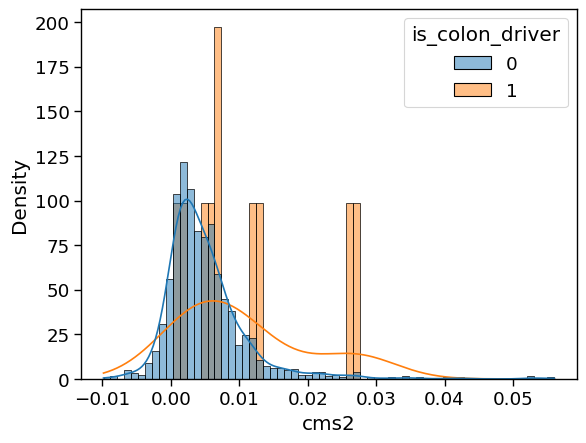

In [185]:
sns.histplot(data = dragon_trans_same, x = 'cms2', hue = 'is_colon_driver', stat = 'density', common_norm  = False, kde = True)

In [186]:
dragon_trans_same_oncokb.sort_values(by = 'cms2', ascending = False)

node1              node2      cms2      cms4      mean  abs_mean  \
57      BRF2_cnv    BRF2_expression  0.056053  0.036068  0.046061  0.046061   
947   ZNF337_cnv  ZNF337_expression  0.052950  0.028097  0.040524  0.040524   
734    ZBED1_cnv   ZBED1_expression  0.052829  0.015313  0.034071  0.034071   
233     GZF1_cnv    GZF1_expression  0.042655  0.027883  0.035269  0.035269   
1180  ZNF703_cnv  ZNF703_expression  0.040671  0.021094  0.030882  0.030882   
...          ...                ...       ...       ...       ...       ...   
1132  ZNF625_cnv  ZNF625_expression       NaN  0.000530  0.000530  0.000530   
1133  ZNF626_cnv  ZNF626_expression       NaN -0.000196 -0.000196  0.000196   
1152  ZNF667_cnv  ZNF667_expression       NaN  0.000213  0.000213  0.000213   
1166  ZNF683_cnv  ZNF683_expression       NaN -0.002407 -0.002407  0.002407   
1250  ZNF831_cnv  ZNF831_expression       NaN  0.001420  0.001420  0.001420   

           var node1_type  node2_type node1_tf  ... Is Oncogene  \
57    0.000200        cnv  expression     BRF2  ...         NaN   
947   0.000309        cnv  expression   ZNF337  ...         NaN   
734   0.000704        cnv  expression    ZBED1  ...         NaN   
233   0.000109        cnv  expression     GZF1  ...         NaN   
1180  0.000192        cnv  expression   ZNF703  ...          No   
...        ...        ...         ...      ...  ...         ...   
1132       NaN        cnv  expression   ZNF625  ...         NaN   
1133       NaN        cnv  expression   ZNF626  ...         NaN   
1152       NaN        cnv  expression   ZNF667  ...         NaN   
1166       NaN        cnv  expression   ZNF683  ...         NaN   
1250       NaN        cnv  expression   ZNF831  ...         NaN   

      Is Tumor Suppressor Gene  MSK-IMPACT  MSK-HEME FOUNDATION ONE  \
57                         NaN         NaN       NaN            NaN   
947                        NaN         NaN       NaN            NaN   
734                        NaN         NaN       NaN            NaN   
233                        NaN         NaN       NaN            NaN   
1180                        No          No        No            Yes   
...                        ...         ...       ...            ...   
1132                       NaN         NaN       NaN            NaN   
1133                       NaN         NaN       NaN            NaN   
1152                       NaN         NaN       NaN            NaN   
1166                       NaN         NaN       NaN            NaN   
1250                       NaN         NaN       NaN            NaN   

      FOUNDATION ONE HEME Vogelstein  SANGER CGC(05/30/2017)  \
57                    NaN        NaN                     NaN   
947                   NaN        NaN                     NaN   
734                   NaN        NaN                     NaN   
233                   NaN        NaN                     NaN   
1180                  Yes         No                      No   
...                   ...        ...                     ...   
1132                  NaN        NaN                     NaN   
1133                  NaN        NaN                     NaN   
1152                  NaN        NaN                     NaN   
1166                  NaN        NaN                     NaN   
1250                  NaN        NaN                     NaN   

                               Gene Aliases  in_oncokb  
57                                      NaN          0  
947                                     NaN          0  
734                                     NaN          0  
233                                     NaN          0  
1180  FLJ14299, NLZ1, ZEPPO1, ZNF503L, Zpo1          1  
...                                     ...        ...  
1132                                    NaN          0  
1133                                    NaN          0  
1152                                    NaN          0  
1166                                    NaN          0  
1250    

In [187]:
dragon_trans_same_oncokb.sort_values(by = 'mean', ascending = False).head(20)

node1              node2      cms2      cms4      mean  abs_mean  \
57      BRF2_cnv    BRF2_expression  0.056053  0.036068  0.046061  0.046061   
947   ZNF337_cnv  ZNF337_expression  0.052950  0.028097  0.040524  0.040524   
233     GZF1_cnv    GZF1_expression  0.042655  0.027883  0.035269  0.035269   
734    ZBED1_cnv   ZBED1_expression  0.052829  0.015313  0.034071  0.034071   
1180  ZNF703_cnv  ZNF703_expression  0.040671  0.021094  0.030882  0.030882   
586    SMAD4_cnv   SMAD4_expression  0.027467  0.031353  0.029410  0.029410   
860    ZNF18_cnv   ZNF18_expression  0.036304  0.015480  0.025892  0.025892   
661    TEAD4_cnv   TEAD4_expression  0.025747  0.024150  0.024949  0.024949   
833   ZNF133_cnv  ZNF133_expression  0.034557  0.014806  0.024681  0.024681   
831   ZNF131_cnv  ZNF131_expression  0.027000  0.021018  0.024009  0.024009   
974   ZNF395_cnv  ZNF395_expression  0.032108  0.015531  0.023820  0.023820   
684    THAP1_cnv   THAP1_expression  0.033887  0.010604  0.022246  0.022246   
1050  ZNF519_cnv  ZNF519_expression  0.027276  0.016914  0.022095  0.022095   
307     IRF2_cnv    IRF2_expression  0.021963  0.019639  0.020801  0.020801   
208    GATA6_cnv   GATA6_expression  0.025207  0.015755  0.020481  0.020481   
744   ZBTB14_cnv  ZBTB14_expression  0.017723  0.021355  0.019539  0.019539   
191    FOXM1_cnv   FOXM1_expression  0.022629  0.016256  0.019442  0.019442   
1110  ZNF596_cnv  ZNF596_expression  0.026943  0.011169  0.019056  0.019056   
475    OVOL2_cnv   OVOL2_expression  0.027494  0.010307  0.018901  0.018901   
442    NFXL1_cnv   NFXL1_expression  0.023969  0.013764  0.018866  0.018866   

           var node1_type  node2_type node1_tf  ... Is Oncogene  \
57    0.000200        cnv  expression     BRF2  ...         NaN   
947   0.000309        cnv  expression   ZNF337  ...         NaN   
233   0.000109        cnv  expression     GZF1  ...         NaN   
734   0.000704        cnv  expression    ZBED1  ...         NaN   
1180  0.000192        cnv  expression   ZNF703  ...          No   
586   0.000008        cnv  expression    SMAD4  ...          No   
860   0.000217        cnv  expression    ZNF18  ...         NaN   
661   0.000001        cnv  expression    TEAD4  ...         NaN   
833   0.000195        cnv  expression   ZNF133  ...         NaN   
831   0.000018        cnv  expression   ZNF131  ...         NaN   
974   0.000137        cnv  expression   ZNF395  ...         NaN   
684   0.000271        cnv  expression    THAP1  ...         NaN   
1050  0.000054        cnv  expression   ZNF519  ...         NaN   
307   0.000003        cnv  expression     IRF2  ...          No   
208   0.000045        cnv  expression    GATA6  ...          No   
744   0.000007        cnv  expression   ZBTB14  ...         NaN   
191   0.000020        cnv  expression    FOXM1  ...         NaN   
1110  0.000124        cnv  expression   ZNF596  ...         NaN   
475   0.000148        cnv  expression    OVOL2  ...         NaN   
442   0.000052        cnv  expression    NFXL1  ...         NaN   

      Is Tumor Suppressor Gene  MSK-IMPACT  MSK-HEME FOUNDATION ONE  \
57                         NaN         NaN       NaN            NaN   
947                        NaN         NaN       NaN            NaN   
233                        NaN         NaN       NaN            NaN   
734                        NaN         NaN       NaN            NaN   
1180                        No          No        No            Yes   
586                        Yes         Yes       Yes            Yes   
860                        NaN         NaN       NaN            NaN   
661                        NaN         NaN       NaN            NaN   
833                        NaN         NaN       NaN            NaN   
831                        NaN         NaN       NaN            NaN   
974                        NaN         NaN       NaN            NaN   
684                        NaN         NaN       NaN            NaN   
1050                

SMAD4-SMAD4
SMAD4
0.0274666637403883
0.0313527119640741
---
ZNF703-ZNF703
ZNF703
0.0406710505629657
0.0210936115312876
---
IRF2-IRF2
IRF2
0.0219632150056907
0.0196386199099001
---
GATA6-GATA6
GATA6
0.0252068790773463
0.0157553477095939
---


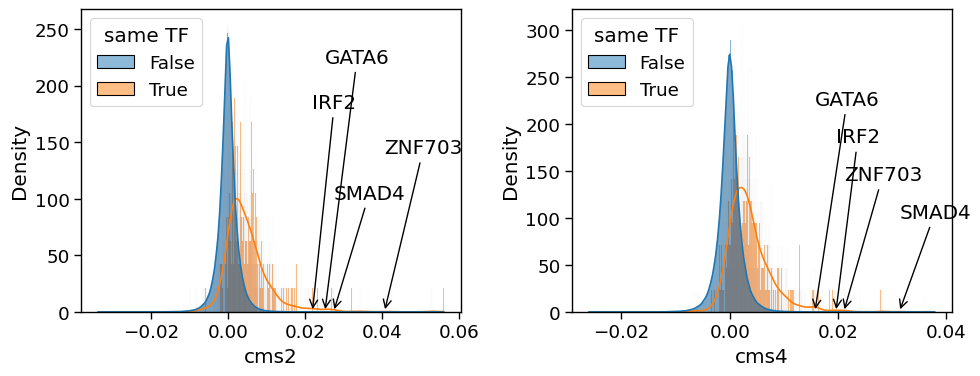

In [188]:

sns.set_context('paper', font_scale = 1.5)
f, ax = plt.subplots(1,2, figsize = (10,4))
sns.histplot(x = 'cms2', data = dragon_trans, hue = 'same TF', stat = 'density', common_norm  = False, kde = True, ax = ax[0])
sns.histplot(x = 'cms4', data = dragon_trans, hue = 'same TF', stat = 'density', common_norm  = False, kde = True, ax = ax[1])
plt.tight_layout()
# annotate
kkk = 0
for k, tab in dragon_trans_same.sort_values(by = 'mean', ascending = False).loc[['SMAD4-SMAD4','ZNF703-ZNF703','IRF2-IRF2','GATA6-GATA6'],:].iterrows():
    print(k)
    print(tab.node1_tf)
    print(tab.cms2)
    print(tab.cms4)
    ax[0].annotate(tab.node1_tf, xy = (tab.cms2, 0), xytext = (tab.cms2, 100+40*kkk), arrowprops=dict(arrowstyle="->", lw=1))
    ax[1].annotate(tab.node1_tf, xy = (tab.cms4, 0), xytext = (tab.cms4, 100+40*kkk), arrowprops=dict(arrowstyle="->", lw=1))
    kkk += 1
    print('---')
f.savefig(output_folder+'dragon_cnv_sametf_values_annotated.pdf')

## DRAGON "TRANS": CNV to expression 

Here we start looking into the CNV to expression edges (and viceversa).

- First we'll check the cnv to expression edges of the same node (TF1_cnv to TF1_expression)
- Secondly we'll check the cnv to expression edges of different nodes

In [189]:
# Get only cnv to expression edges
dragon_trans = dragon[(dragon.node1_type!=dragon.node2_type)]
dragon_trans.head()

node1              node2      cms2      cms4  \
edge                                                                       
AC008770.3-ADNP2   AC008770.3_cnv   ADNP2_expression -0.000867  0.001317   
AC008770.3-ADNP    AC008770.3_cnv    ADNP_expression  0.000369 -0.000656   
AC008770.3-AEBP1   AC008770.3_cnv   AEBP1_expression  0.000287 -0.001124   
AC008770.3-AEBP2   AC008770.3_cnv   AEBP2_expression -0.001812 -0.000214   
AC008770.3-AHCTF1  AC008770.3_cnv  AHCTF1_expression -0.000704  0.000619   

                       mean  abs_mean           var node1_type  node2_type  \
edge                                                                         
AC008770.3-ADNP2   0.000225  0.001092  2.385443e-06        cnv  expression   
AC008770.3-ADNP   -0.000143  0.000513  5.257575e-07        cnv  expression   
AC008770.3-AEBP1  -0.000419  0.000705  9.952867e-07        cnv  expression   
AC008770.3-AEBP2  -0.001013  0.001013  1.275843e-06        cnv  expression   
AC008770.3-AHCTF1 -0.000043  0.000662  8.756109e-07        cnv  expression   

                     node1_tf node2_tf  cms2_abs  cms4_abs  same  \
edge                                                               
AC008770.3-ADNP2   AC008770.3    ADNP2  0.000867  0.001317     0   
AC008770.3-ADNP    AC008770.3     ADNP  0.000369  0.000656     0   
AC008770.3-AEBP1   AC008770.3    AEBP1  0.000287  0.001124     0   
AC008770.3-AEBP2   AC008770.3    AEBP2  0.001812  0.000214     0   
AC008770.3-AHCTF1  AC008770.3   AHCTF1  0.000704  0.000619     0   

                        edge_type  
edge                               
AC008770.3-ADNP2   cnv-expression  
AC008770.3-ADNP    cnv-expression  
AC008770.3-AEBP1   cnv-expression  
AC008770.3-AEBP2   cnv-expression  
AC008770.3-AHCTF1  cnv-expression

In [190]:
# check that the number of edges is correct
dragon[(dragon.node2_type=='cnv') & (dragon.node1_type=='expression')].shape, dragon[(dragon.node1_type=='cnv') & (dragon.node2_type=='expression')].shape, dragon_trans.shape

((0, 15), (2102662, 15), (2102662, 15))

#### Is the pattern the same?
We now check if the above edges are correlated between different subtypes


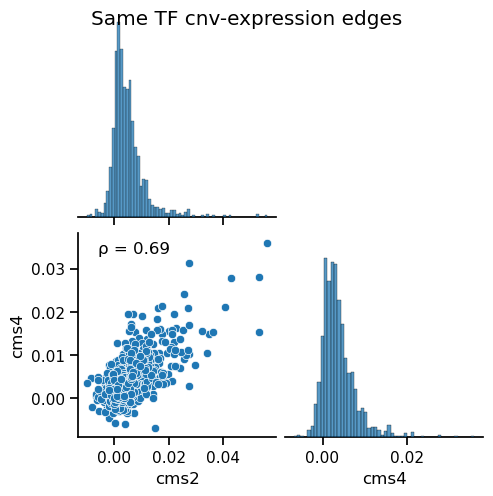

In [191]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt 

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
sns.set_context('notebook', font_scale = 1)
g = sns.pairplot(data = dragon_trans[dragon_trans['same']==1].loc[:,subtype_order].dropna(axis =0), corner = True)

g.map_lower(corrfunc)
g.fig.suptitle('Same TF cnv-expression edges')
g.fig.savefig(output_folder+'dragon_same_tf_edges.pdf')
plt.show()


## Check which edges are different between cms2 and cms4


<Axes: xlabel='edge_type', ylabel='cms2vscms4'>

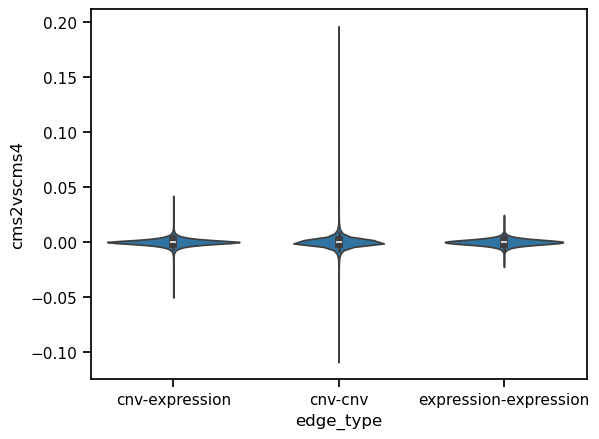

In [192]:
dragon['cms2vscms4'] = dragon.cms2 - dragon.cms4
sns.violinplot(data = dragon.reset_index(), y = 'cms2vscms4', x = 'edge_type')

## CNV to expression

In [193]:
dragon_cnv_expression = dragon[(dragon.node1_type=='cnv') & (dragon.node2_type=='expression')]
dragon_cnv_expression.dropna(inplace = True)

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/2099831500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_cnv_expression.dropna(inplace = True)


In [194]:
cms2_th = np.percentile(dragon_cnv_expression.cms2.dropna(), 99.99)
cms4_th = np.percentile(dragon_cnv_expression.cms4.dropna(), 99.99)
dragon_cnv_expression['cms2_th'] = (dragon_cnv_expression.cms2>cms2_th)
dragon_cnv_expression['cms4_th'] = (dragon_cnv_expression.cms4>cms4_th)
dragon_cnv_expression.sort_values(by = 'cms2vscms4', ascending = False)

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/1726941688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_cnv_expression['cms2_th'] = (dragon_cnv_expression.cms2>cms2_th)
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/1726941688.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dragon_cnv_expression['cms4_th'] = (dragon_cnv_expression.cms4>cms4_th)


node1              node2      cms2      cms4      mean  \
edge                                                                       
ZMAT4-FOXD1   ZMAT4_cnv   FOXD1_expression  0.030211 -0.011663  0.009274   
ZMAT4-ZNF256  ZMAT4_cnv  ZNF256_expression  0.029406 -0.010536  0.009435   
ZMAT4-ZFP82   ZMAT4_cnv   ZFP82_expression  0.013023 -0.025982 -0.006479   
GSC2-ZNF701    GSC2_cnv  ZNF701_expression  0.034413 -0.004445  0.014984   
ZBED1-ZBED1   ZBED1_cnv   ZBED1_expression  0.052829  0.015313  0.034071   
...                 ...                ...       ...       ...       ...   
FOXN1-FOXD1   FOXN1_cnv   FOXD1_expression -0.022987  0.011144 -0.005922   
SEBOX-FOXD1   SEBOX_cnv   FOXD1_expression -0.022987  0.011144 -0.005922   
ZMAT4-TBX19   ZMAT4_cnv   TBX19_expression -0.022839  0.012317 -0.005261   
ZMAT4-PAX6    ZMAT4_cnv    PAX6_expression -0.019852  0.018271 -0.000791   
ZMAT4-PAX8    ZMAT4_cnv    PAX8_expression -0.030135  0.019944 -0.005095   

              abs_mean       var node1_type  node2_type node1_tf node2_tf  \
edge                                                                        
ZMAT4-FOXD1   0.020937  0.000877        cnv  expression    ZMAT4    FOXD1   
ZMAT4-ZNF256  0.019971  0.000798        cnv  expression    ZMAT4   ZNF256   
ZMAT4-ZFP82   0.019502  0.000761        cnv  expression    ZMAT4    ZFP82   
GSC2-ZNF701   0.019429  0.000755        cnv  expression     GSC2   ZNF701   
ZBED1-ZBED1   0.034071  0.000704        cnv  expression    ZBED1    ZBED1   
...                ...       ...        ...         ...      ...      ...   
FOXN1-FOXD1   0.017065  0.000582        cnv  expression    FOXN1    FOXD1   
SEBOX-FOXD1   0.017065  0.000582        cnv  expression    SEBOX    FOXD1   
ZMAT4-TBX19   0.017578  0.000618        cnv  expression    ZMAT4    TBX19   
ZMAT4-PAX6    0.019061  0.000727        cnv  expression    ZMAT4     PAX6   
ZMAT4-PAX8    0.025039  0.001254        cnv  expression    ZMAT4     PAX8   

              cms2_abs  cms4_abs  same       edge_type  cms2vscms4  cms2_th  \
edge                                                                          
ZMAT4-FOXD1   0.030211  0.011663     0  cnv-expression    0.041874     True   
ZMAT4-ZNF256  0.029406  0.010536     0  cnv-expression    0.039942     True   
ZMAT4-ZFP82   0.013023  0.025982     0  cnv-expression    0.039005    False   
GSC2-ZNF701   0.034413  0.004445     0  cnv-expression    0.038858     True   
ZBED1-ZBED1   0.052829  0.015313     1  cnv-expression    0.037516     True   
...                ...       ...   ...             ...         ...      ...   
FOXN1-FOXD1   0.022987  0.011144     0  cnv-expression   -0.034131    False   
SEBOX-FOXD1   0.022987  0.011144     0  cnv-expression   -0.034131    False   
ZMAT4-TBX19   0.022839  0.012317     0  cnv-expression   -0.035156    False   
ZMAT4-PAX6    0.019852  0.018271     0  cnv-expression   -0.038123    False   
ZMAT4-PAX8    0.030135  0.019944     0  cnv-expression   -0.050079    False   

              cms4_th  
edge                   
ZMAT4-FOXD1     False  
ZMAT4-ZNF256    False  
ZMAT4-ZFP82     False  
GSC2-ZNF701     False  
ZBED1-ZBED1      True  
...               ...  
FOXN1-FOXD1     False  
SEBOX-FOXD1     False  
ZMAT4-TBX19     False  
ZMAT4-PAX6       True  
ZMAT4-PAX8       True  

[2017389 rows x 18 columns]

In [195]:
len(dragon_cnv_expression.node2.unique())

1243

In [196]:
from scipy.stats import wilcoxon
test_cnv = pd.DataFrame()
kkk = 0
for n1 in dragon_cnv_expression.node1.unique():
    ttt = dragon_cnv_expression[dragon_cnv_expression['node1']==n1].sort_values(by = 'cms2vscms4', ascending = False)
    #s,p = stats.spearmanr(ttt.cms2, ttt.cms4)

    # Perform the Wilcoxon signed-rank test
    s, p = wilcoxon(ttt.cms2, ttt.cms4)
    rho,pval = stats.spearmanr(ttt.cms2.values, ttt.cms4.values)
    tt, ttp = stats.ttest_rel(ttt.cms2, ttt.cms4)
    test_cnv = pd.concat([test_cnv, pd.DataFrame(data = {'node1': [n1], 'stat': [s], 'pval': [p],'test':'wilkoxon','rho':[rho], 'ttest':[tt], 'ttest_pval':[ttp]})], ignore_index = True)
    #kkk += 1
    #if kkk>10:
    #    break
    
test_cnv

node1      stat          pval      test       rho     ttest  \
0     AC008770.3_cnv  359864.0  3.485955e-02  wilkoxon  0.121174  1.918724   
1     AC023509.3_cnv  370277.0  1.979658e-01  wilkoxon  0.008453 -1.367204   
2     AC092835.1_cnv  362104.0  5.323272e-02  wilkoxon  0.005185  1.707202   
3     AC138696.1_cnv  379089.0  5.543670e-01  wilkoxon  0.018998 -0.001325   
4          ADNP2_cnv  385499.0  9.323846e-01  wilkoxon  0.068218 -0.027181   
...              ...       ...           ...       ...       ...       ...   
1618      ZSCAN9_cnv  328939.0  5.287814e-06  wilkoxon  0.167406  3.789229   
1619        ZXDA_cnv  301717.0  2.034230e-11  wilkoxon -0.098365  6.721041   
1620        ZXDB_cnv  301717.0  2.034230e-11  wilkoxon -0.098365  6.721041   
1621        ZXDC_cnv  334328.0  3.670373e-05  wilkoxon  0.037682 -4.253829   
1622        ZZZ3_cnv  380329.0  6.218217e-01  wilkoxon -0.049087 -0.434261   

        ttest_pval  
0     5.524828e-02  
1     1.718086e-01  
2     8.803439e-02  
3     9.989429e-01  
4     9.783199e-01  
...            ...  
1618  1.583561e-04  
1619  2.742612e-11  
1620  2.742612e-11  
1621  2.259178e-05  
1622  6.641747e-01  

[1623 rows x 7 columns]

In [197]:
from statsmodels.stats.multitest import multipletests

test_cnv['padj'] = multipletests(test_cnv.pval, method='fdr_bh')[1]
test_cnv['significant'] = (test_cnv['padj'] < 0.05)
test_cnv.sort_values(by='padj', ascending=True)

node1      stat          pval      test       rho      ttest  \
1366   ZNF554_cnv  248258.0  8.586307e-28  wilkoxon  0.030227  10.973871   
1392    ZNF57_cnv  248258.0  8.586307e-28  wilkoxon  0.030227  10.973871   
157     DOT1L_cnv  248258.0  8.586307e-28  wilkoxon  0.030227  10.973871   
653   ONECUT3_cnv  248258.0  8.586307e-28  wilkoxon  0.030227  10.973871   
1368   ZNF556_cnv  248258.0  8.586307e-28  wilkoxon  0.030227  10.973871   
...           ...       ...           ...       ...       ...        ...   
942    THAP12_cnv  386219.0  9.776895e-01  wilkoxon -0.006165  -0.004211   
67       BCL6_cnv  386549.0  9.984872e-01  wilkoxon  0.083155   0.449710   
1019   ZBTB22_cnv  386556.0  9.989285e-01  wilkoxon -0.080572  -0.107074   
1049    ZBTB9_cnv  386556.0  9.989285e-01  wilkoxon -0.080572  -0.107074   
683      PHF1_cnv  386556.0  9.989285e-01  wilkoxon -0.080572  -0.107074   

        ttest_pval          padj  significant  
1366  8.303825e-27  1.990797e-25         True  
1392  8.303825e-27  1.990797e-25         True  
157   8.303825e-27  1.990797e-25         True  
653   8.303825e-27  1.990797e-25         True  
1368  8.303825e-27  1.990797e-25         True  
...            ...           ...          ...  
942   9.966404e-01  9.801051e-01        False  
67    6.529981e-01  9.989285e-01        False  
1019  9.147472e-01  9.989285e-01        False  
1049  9.147472e-01  9.989285e-01        False  
683   9.147472e-01  9.989285e-01        False  

[1623 rows x 9 columns]

In [198]:
test_cnv['TF'] = test_cnv.node1.str.split('_').str[0]
test_cnv

node1      stat          pval      test       rho     ttest  \
0     AC008770.3_cnv  359864.0  3.485955e-02  wilkoxon  0.121174  1.918724   
1     AC023509.3_cnv  370277.0  1.979658e-01  wilkoxon  0.008453 -1.367204   
2     AC092835.1_cnv  362104.0  5.323272e-02  wilkoxon  0.005185  1.707202   
3     AC138696.1_cnv  379089.0  5.543670e-01  wilkoxon  0.018998 -0.001325   
4          ADNP2_cnv  385499.0  9.323846e-01  wilkoxon  0.068218 -0.027181   
...              ...       ...           ...       ...       ...       ...   
1618      ZSCAN9_cnv  328939.0  5.287814e-06  wilkoxon  0.167406  3.789229   
1619        ZXDA_cnv  301717.0  2.034230e-11  wilkoxon -0.098365  6.721041   
1620        ZXDB_cnv  301717.0  2.034230e-11  wilkoxon -0.098365  6.721041   
1621        ZXDC_cnv  334328.0  3.670373e-05  wilkoxon  0.037682 -4.253829   
1622        ZZZ3_cnv  380329.0  6.218217e-01  wilkoxon -0.049087 -0.434261   

        ttest_pval          padj  significant          TF  
0     5.524828e-02  5.939049e-02        False  AC008770.3  
1     1.718086e-01  2.681957e-01        False  AC023509.3  
2     8.803439e-02  8.583644e-02        False  AC092835.1  
3     9.989429e-01  6.449732e-01        False  AC138696.1  
4     9.783199e-01  9.447933e-01        False       ADNP2  
...            ...           ...          ...         ...  
1618  1.583561e-04  2.240763e-05         True      ZSCAN9  
1619  2.742612e-11  3.512293e-10         True        ZXDA  
1620  2.742612e-11  3.512293e-10         True        ZXDB  
1621  2.259178e-05  1.350797e-04         True        ZXDC  
1622  6.641747e-01  7.077255e-01        False        ZZZ3  

[1623 rows x 10 columns]

In [199]:
test_cnv = test_cnv.sort_values(by = 'padj', ascending = True).reset_index()

In [200]:
test_cnv['-log10(padj)'] = -np.log10(test_cnv['padj'])

In [201]:
test_cnv['sign'] = np.sign(test_cnv['ttest'])
test_cnv['effect'] = test_cnv['sign'].map({1:'Higher CMS2', -1:'Higher CMS4'})

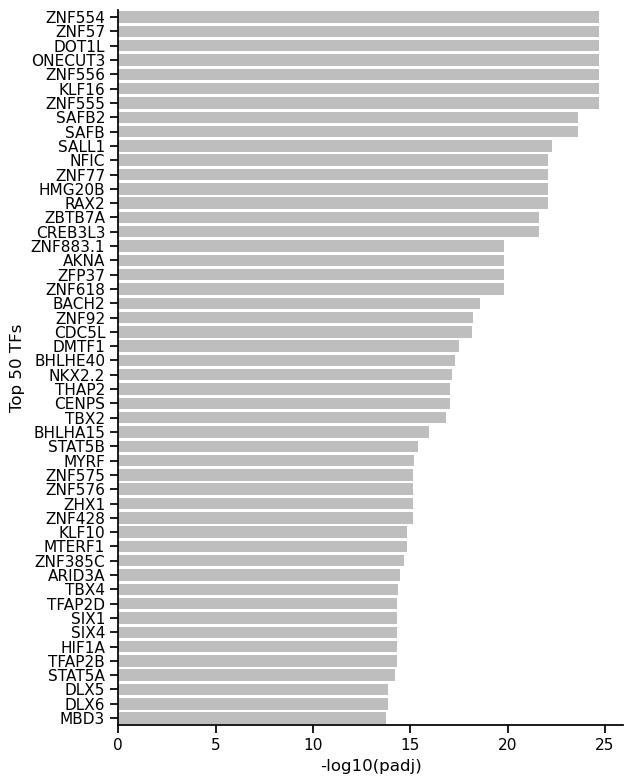

In [202]:
# Plot bubble plot of 
color_gray = "#BEBEBE"
g1 = sns.catplot(data = test_cnv.iloc[:50], y = 'TF', x = '-log10(padj)', kind = 'bar', height = 8, aspect = .8, color = color_gray)
g1.set(xlabel='-log10(padj)', ylabel='Top 50 TFs')

g1.savefig(output_folder + 'dragon_cnv_top_tf_wilkoxon_top50_old.png')
g1.savefig(output_folder + 'dragon_cnv_top_tf_wilkoxon_top50_old.pdf')

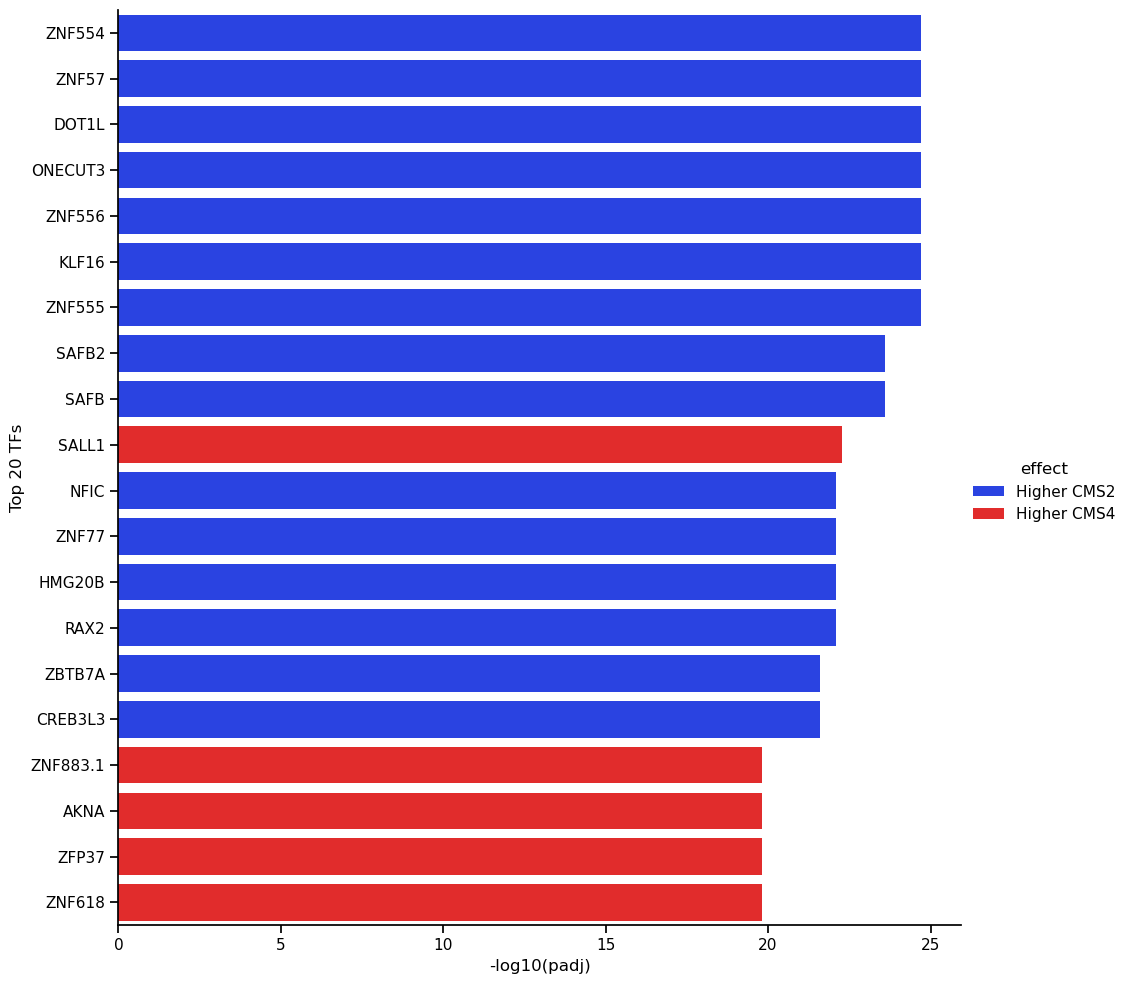

In [203]:
# Plot bubble plot of 
g1 = sns.catplot(data = test_cnv.iloc[:20], y = 'TF', x = '-log10(padj)', hue = 'effect', kind = 'bar', height = 10, aspect = 1, palette = ["#0c2dff", "#ff0e0e"])
g1.set(xlabel='-log10(padj)', ylabel='Top 20 TFs')
g1.savefig(output_folder + 'dragon_cnv_top_tf_wilkoxon.png')
g1.savefig(output_folder + 'dragon_cnv_top_tf_wilkoxon.pdf')

In [204]:
mytf = test_cnv.sort_values(by = 'stat', ascending = True).iloc[np.r_[np.arange(20)],:].node1.tolist()
temp_cnv_expression = dragon_cnv_expression[dragon_cnv_expression['node1'].isin(mytf)].sort_values(by = 'cms2vscms4', ascending = False)
temp_cnv_expression['Top 20 TF'] = temp_cnv_expression['node1'].str.replace('_cnv', '')
mytf = [i.replace('_cnv', '') for i in mytf]



In [205]:
test_cnv['is_driver'] = 1*(test_cnv['TF'].isin(all_drivers))
test_cnv['is_colon_driver'] = 1*(test_cnv['TF'].isin(colon_drivers))
test_cnv['is_disgenet'] = 1*(test_cnv['TF'].isin(disgenet_colorectal['Gene']))

test_cnv[test_cnv['is_colon_driver']==1].sort_values(by = 'pval')

index       node1      stat          pval      test       rho     ttest  \
44      343   HIF1A_cnv  281873.0  1.326145e-16  wilkoxon  0.022463  8.268448   
61      128    CUX1_cnv  290817.0  3.889556e-14  wilkoxon  0.081574 -7.383305   
225     817   SMAD3_cnv  317224.0  4.289310e-08  wilkoxon  0.081908  5.170382   
263     818   SMAD4_cnv  319092.0  9.770775e-08  wilkoxon -0.001923 -5.251053   
342     498     MAX_cnv  326207.0  1.852734e-06  wilkoxon -0.025511  4.632249   
445     788   SALL4_cnv  334949.0  4.537636e-05  wilkoxon  0.142631  4.050244   
978     412   IKZF3_cnv  360872.0  4.232046e-02  wilkoxon  0.024088  1.863999   
1056    967    TP53_cnv  365153.0  9.061546e-02  wilkoxon  0.080194 -1.857085   
1163    726   PRDM2_cnv  369650.0  1.812549e-01  wilkoxon -0.032223 -1.127518   
1324    909  TCF7L2_cnv  376480.0  4.252550e-01  wilkoxon  0.077511  0.793507   

        ttest_pval          padj  significant      TF  -log10(padj)  sign  \
44    3.454454e-16  4.678987e-15         True   HIF1A     14.329848   1.0   
61    2.820605e-13  1.018185e-12         True    CUX1     11.992173  -1.0   
225   2.720515e-07  3.080332e-07         True   SMAD3      6.511403   1.0   
263   1.777635e-07  6.006806e-07         True   SMAD4      6.221356  -1.0   
342   3.997745e-06  8.640767e-06         True     MAX      5.063448   1.0   
445   5.433470e-05  1.651252e-04         True   SALL4      3.782187   1.0   
978   6.255759e-02  7.015945e-02        False   IKZF3      1.153914   1.0   
1056  6.353566e-02  1.391380e-01        False    TP53      0.856554  -1.0   
1163  2.597415e-01  2.527291e-01        False   PRDM2      0.597345  -1.0   
1324  4.276343e-01  5.208972e-01        False  TCF7L2      0.283248   1.0   

           effect  is_driver  is_colon_driver  is_disgenet  
44    Higher CMS2          1                1            0  
61    Higher CMS4          1                1            0  
225   Higher CMS2          1                1            1  
263   Higher CMS4          1                1            1  
342   Higher CMS2          1                1            0  
445   Higher CMS2          1                1            0  
978   Higher CMS2          1                1            0  
1056  Higher CMS4          1                1            1  
1163  Higher CMS4          1                1            0  
1324  Higher CMS2          1                1            1

In [206]:
test_cnv['any_colon_driver'] = (test_cnv['is_colon_driver']==1) | (test_cnv['is_disgenet']==1)
n_permutations = 10
for aaa in ['is_colon_driver', 'is_disgenet', 'any_colon_driver']:
    print(aaa)
    
    PP = test_cnv[(test_cnv['padj']<0.01) & (test_cnv[aaa]==1)]
    PN = test_cnv[(test_cnv['padj']<0.01) & (test_cnv[aaa]==0)]
    NP = test_cnv[(test_cnv['padj']>=0.01) & (test_cnv[aaa]==1)]
    NN = test_cnv[(test_cnv['padj']>=0.01) & (test_cnv[aaa]==0)]
    print('PP:', PP.shape[0], 'PN:', PN.shape[0], 'NP:', NP.shape[0], 'NN:', NN.shape[0])
    print(stats.fisher_exact([[PP.shape[0], NP.shape[0]], [PN.shape[0], NN.shape[0]]], alternative='greater'))
    drivers = test_cnv[test_cnv[aaa]==1]
    others = test_cnv[test_cnv[aaa]==0]
    
    ks,p = stats.ks_2samp(others['stat'], drivers['stat'], alternative='less')
    print('KS test p-value:', p)
    print('KS test statistic:', ks)


is_colon_driver
PP: 6 PN: 726 NP: 4 NN: 887
SignificanceResult(statistic=np.float64(1.8326446280991735), pvalue=np.float64(0.26310829347353715))
KS test p-value: 0.09492552520756521
KS test statistic: 0.3272163670179789
is_disgenet
PP: 23 PN: 709 NP: 18 NN: 873
SignificanceResult(statistic=np.float64(1.573342736248237), pvalue=np.float64(0.10156473563376102))
KS test p-value: 0.05634269060991044
KS test statistic: 0.1852856834510191
any_colon_driver
PP: 27 PN: 705 NP: 20 NN: 871
SignificanceResult(statistic=np.float64(1.667872340425532), pvalue=np.float64(0.057697246811195944))
KS test p-value: 0.013597226800331907
KS test statistic: 0.21271195593476616


<Axes: xlabel='stat', ylabel='Density'>

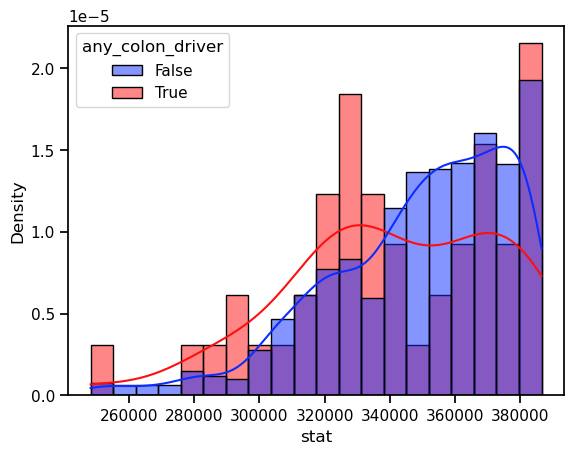

In [207]:
test_cnv['rank_stat'] = test_cnv.sort_values(by = 'stat', ascending = True).index.tolist()
sns.histplot(data = test_cnv, x = 'stat', stat = 'density', common_norm  = False, kde = True, hue = 'any_colon_driver', palette = ['#0c2dff', '#ff0e0e'])

In [208]:
# Get the drivers table of significant edges
drivers_table = test_cnv[test_cnv['padj']<0.01].sort_values(by = 'padj', ascending = True)
drivers_table['any_colon_driver'] = (drivers_table['is_colon_driver']==1) | (drivers_table['is_disgenet']==1)
#drivers_table['any_driver'] = drivers_table['is_disgenet']==1
drivers_table = drivers_table[drivers_table['any_colon_driver']==1].sort_values(by = 'padj', ascending = True)
drivers_table

index        node1      stat          pval      test       rho  \
2      157    DOT1L_cnv  248258.0  8.586307e-28  wilkoxon  0.030227   
44     343    HIF1A_cnv  281873.0  1.326145e-16  wilkoxon  0.022463   
50     906     TCF3_cnv  284102.0  5.721093e-16  wilkoxon  0.068043   
61     128     CUX1_cnv  290817.0  3.889556e-14  wilkoxon  0.081574   
62     287    GATA4_cnv  292030.0  8.092390e-14  wilkoxon  0.168300   
99     671     PAX8_cnv  302831.0  3.701978e-11  wilkoxon  0.042060   
156    616     NME2_cnv  310275.0  1.665451e-09  wilkoxon  0.041891   
157    458     KLF2_cnv  310654.0  2.003410e-09  wilkoxon -0.005981   
225    817    SMAD3_cnv  317224.0  4.289310e-08  wilkoxon  0.081908   
263    818    SMAD4_cnv  319092.0  9.770775e-08  wilkoxon -0.001923   
274    550      MYC_cnv  320254.0  1.613273e-07  wilkoxon  0.064929   
277    265    FOXL2_cnv  320631.0  1.894966e-07  wilkoxon -0.045077   
299    820    SMAD9_cnv  323305.0  5.789403e-07  wilkoxon  0.104038   
314     31     ARNT_cnv  324437.0  9.168857e-07  wilkoxon  0.163699   
346    202     ESR2_cnv  326207.0  1.852734e-06  wilkoxon -0.025511   
342    498      MAX_cnv  326207.0  1.852734e-06  wilkoxon -0.025511   
378   1093  ZKSCAN3_cnv  328939.0  5.287814e-06  wilkoxon  0.167406   
398    399    HOXD1_cnv  329872.0  7.487902e-06  wilkoxon  0.027887   
390    403    HOXD9_cnv  329872.0  7.487902e-06  wilkoxon  0.027887   
418    837    SOX17_cnv  332396.0  1.869499e-05  wilkoxon -0.175573   
431    969     TP73_cnv  333878.0  3.142917e-05  wilkoxon -0.076709   
445    788    SALL4_cnv  334949.0  4.537636e-05  wilkoxon  0.142631   
458    790    SATB2_cnv  336266.0  7.061438e-05  wilkoxon  0.057663   
561     22    ARID2_cnv  341892.0  4.159409e-04  wilkoxon  0.089122   
589    718    PPARG_cnv  343725.0  7.119067e-04  wilkoxon  0.069748   
590    410    IKZF1_cnv  343814.0  7.303601e-04  wilkoxon  0.001731   
693    194     EMX2_cnv  348758.0  2.814075e-03  wilkoxon  0.028004   

         ttest    ttest_pval          padj  significant       TF  \
2    10.973871  8.303825e-27  1.990797e-25         True    DOT1L   
44    8.268448  3.454454e-16  4.678987e-15         True    HIF1A   
50    7.933787  4.712255e-15  1.820654e-14         True     TCF3   
61   -7.383305  2.820605e-13  1.018185e-12         True     CUX1   
62   -6.697991  3.194196e-11  2.084754e-12         True    GATA4   
99    6.649201  4.403631e-11  6.008310e-10         True     PAX8   
156   5.993014  2.695251e-09  1.721674e-08         True     NME2   
157   5.562880  3.246811e-08  2.057933e-08         True     KLF2   
225   5.170382  2.720515e-07  3.080332e-07         True    SMAD3   
263  -5.251053  1.777635e-07  6.006806e-07         True    SMAD4   
274  -5.095455  4.017982e-07  9.486745e-07         True      MYC   
277  -5.076927  4.421260e-07  1.106306e-06         True    FOXL2   
299  -3.815102  1.428218e-04  3.121661e-06         True    SMAD9   
314  -5.038856  5.376144e-07  4.679577e-06         True     ARNT   
346   4.632249  3.997745e-06  8.640767e-06         True     ESR2   
342   4.632249  3.997745e-06  8.640767e-06         True      MAX   
378   3.789229  1.583561e-04  2.240763e-05         True  ZKSCAN3   
398   4.454138  9.181122e-06  3.008135e-05         True    HOXD1   
390   4.454138  9.181122e-06  3.008135e-05         True    HOXD9   
418   4.151433  3.529407e-05  7.241522e-05         True    SOX17   
431   4.033853  5.821655e-05  1.180776e-04         True     TP73   
445   4.050244  5.433470e-05  1.651252e-04         True    SALL4   
458   3.940305  8.591074e-05  2.496887e-04         True    SATB2   
561   3.014761  2.624007e-03  1.201196e-03         True    ARID2   
589   2.917148  3.596014e-03  1.958347e-03         True    PPARG   
590  -3.648064  2.751727e-04  2.005710e-03         True    IKZF1   
693   3.247218  1.196531e-03  6.581044e-03         True     EMX2   

     -log10(padj)  sign       effect  is_driver  is_colon_driver  is_disgenet  \
2       24.700973   1.0  Highe

In [209]:
drivers_table[drivers_table['any_colon_driver']==1].sort_values(by = 'padj', ascending = True)
drivers_table['what_colon_driver'] = 1*drivers_table['is_colon_driver'] + 2*drivers_table['is_disgenet']
drivers_table.what_colon_driver = drivers_table.what_colon_driver.map({1:'Cancer Gene Census', 2:'DisGeNET', 3:'Both'})


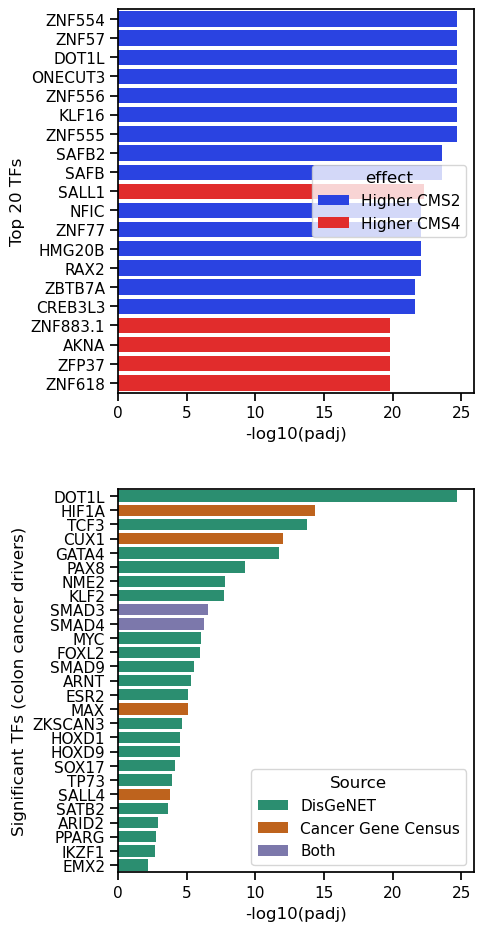

In [210]:
f, ax = plt.subplots(2,1, figsize = (5,10),)
sns.barplot(data = test_cnv.iloc[:20], y = 'TF', x = '-log10(padj)', hue = 'effect', palette = ["#0c2dff", "#ff0e0e"], ax = ax[0])
ax[0].set(xlabel='-log10(padj)', ylabel='Top 20 TFs')

sns.barplot(data = drivers_table[drivers_table['any_colon_driver']==1].sort_values(by = 'padj', ascending = True), y = 'TF', x = '-log10(padj)', hue = 'what_colon_driver', palette = 'Dark2', ax = ax[1])
ax[1].set(xlabel='-log10(padj)', ylabel='Significant TFs (colon cancer drivers)')
# Increase space between subplots
plt.subplots_adjust(hspace=100)

# change legend title
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels, title = 'Source')
plt.tight_layout()
f.savefig(output_folder + 'dragon_cnv_top_tf_wilkoxon_combined.png')
f.savefig(output_folder + 'dragon_cnv_top_tf_wilkoxon_combined.pdf')

## StringDB

In [214]:
# Network
stringdb = pd.read_csv('../data/external/9606.protein.links.detailed.v12.0.txt', sep=' ')
stringdb.head()
# We also need the details for the protein names
stringdb_info = pd.read_csv('../data/external/9606.protein.info.v12.0.txt', sep='\t')
stringdb_info.head()

#string_protein_id preferred_name  protein_size  \
0  9606.ENSP00000000233           ARF5           180   
1  9606.ENSP00000000412           M6PR           277   
2  9606.ENSP00000001008          FKBP4           459   
3  9606.ENSP00000001146        CYP26B1           512   
4  9606.ENSP00000002125        NDUFAF7           441   

                                          annotation  
0  ADP-ribosylation factor 5; GTP-binding protein...  
1  Cation-dependent mannose-6-phosphate receptor;...  
2  Peptidyl-prolyl cis-trans isomerase FKBP4, N-t...  
3  Cytochrome P450 26B1; Involved in the metaboli...  
4  Protein arginine methyltransferase NDUFAF7, mi...

In [215]:
# We rename the proteins with the gene names
stringdb['gene1'] = stringdb['protein1'].map(stringdb_info.set_index('#string_protein_id')['preferred_name'])
stringdb['gene2'] = stringdb['protein2'].map(stringdb_info.set_index('#string_protein_id')['preferred_name'])
# We get the edges
stringdb['edge'] = stringdb['gene1'] + '_' + stringdb['gene2']
stringdb_edges = set(stringdb['edge']).union(set(stringdb['gene2'] + '_' + stringdb['gene1']))
stringdb_genes = set(stringdb['gene1']).union(set(stringdb['gene2']))

In [216]:
# Stringdb values are confidence scores, 0 to 1, multiplied by 1000
stringdb.iloc[:, 2:-3] = 1/1000*stringdb.iloc[:, 2:-3].values

/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/2040608550.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stringdb.iloc[:, 2:-3] = 1/1000*stringdb.iloc[:, 2:-3].values
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/2040608550.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  stringdb.iloc[:, 2:-3] = 1/1000*stringdb.iloc[:, 2:-3].values
/var/folders/1b/jphhn26s4zgfr0k1rxj7wfqr0000gn/T/ipykernel_78952/2040608550.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible 

In [217]:
dragon['edge-tf'] = dragon['node1_tf'] + '_' + dragon['node2_tf']
dragon['edge'] = dragon['node1'] + '_' + dragon['node2']
dragon

node1               node2      cms2      cms4  \
edge                                                                        
AC008770.3-ADNP2   AC008770.3_cnv    ADNP2_expression -0.000867  0.001317   
AC008770.3-ADNP    AC008770.3_cnv            ADNP_cnv  0.000643  0.000043   
AC008770.3-ADNP    AC008770.3_cnv     ADNP_expression  0.000369 -0.000656   
AC008770.3-AEBP1   AC008770.3_cnv    AEBP1_expression  0.000287 -0.001124   
AC008770.3-AEBP2   AC008770.3_cnv    AEBP2_expression -0.001812 -0.000214   
...                           ...                 ...       ...       ...   
ZZZ3-ZSCAN5A      ZZZ3_expression  ZSCAN5A_expression -0.001190  0.002365   
ZZZ3-ZSCAN9       ZZZ3_expression   ZSCAN9_expression  0.000714  0.001843   
ZZZ3-ZXDA         ZZZ3_expression     ZXDA_expression  0.001551  0.002689   
ZZZ3-ZXDB         ZZZ3_expression     ZXDB_expression  0.002013  0.001942   
ZZZ3-ZXDC         ZZZ3_expression     ZXDC_expression -0.000425  0.001952   

                      mean  abs_mean           var  node1_type  node2_type  \
edge                                                                         
AC008770.3-ADNP2  0.000225  0.001092  2.385443e-06         cnv  expression   
AC008770.3-ADNP   0.000343  0.000343  1.797459e-07         cnv         cnv   
AC008770.3-ADNP  -0.000143  0.000513  5.257575e-07         cnv  expression   
AC008770.3-AEBP1 -0.000419  0.000705  9.952867e-07         cnv  expression   
AC008770.3-AEBP2 -0.001013  0.001013  1.275843e-06         cnv  expression   
...                    ...       ...           ...         ...         ...   
ZZZ3-ZSCAN5A      0.000588  0.001778  6.321812e-06  expression  expression   
ZZZ3-ZSCAN9       0.001278  0.001278  6.372003e-07  expression  expression   
ZZZ3-ZXDA         0.002120  0.002120  6.481347e-07  expression  expression   
ZZZ3-ZXDB         0.001978  0.001978  2.507604e-09  expression  expression   
ZZZ3-ZXDC         0.000763  0.001189  2.825171e-06  expression  expression   

                    node1_tf node2_tf  cms2_abs  cms4_abs  same  \
edge                                                              
AC008770.3-ADNP2  AC008770.3    ADNP2  0.000867  0.001317     0   
AC008770.3-ADNP   AC008770.3     ADNP  0.000643  0.000043     0   
AC008770.3-ADNP   AC008770.3     ADNP  0.000369  0.000656     0   
AC008770.3-AEBP1  AC008770.3    AEBP1  0.000287  0.001124     0   
AC008770.3-AEBP2  AC008770.3    AEBP2  0.001812  0.000214     0   
...                      ...      ...       ...       ...   ...   
ZZZ3-ZSCAN5A            ZZZ3  ZSCAN5A  0.001190  0.002365     0   
ZZZ3-ZSCAN9             ZZZ3   ZSCAN9  0.000714  0.001843     0   
ZZZ3-ZXDA               ZZZ3     ZXDA  0.001551  0.002689     0   
ZZZ3-ZXDB               ZZZ3     ZXDB  0.002013  0.001942     0   
ZZZ3-ZXDC               ZZZ3     ZXDC  0.000425  0.001952     0   

                              edge_type  cms2vscms4           edge-tf  \
edge                                                                    
AC008770.3-ADNP2         cnv-expression   -0.002184  AC008770.3_ADNP2   
AC008770.3-ADNP                 cnv-cnv    0.000600   AC008770.3_ADNP   
AC008770.3-ADNP          cnv-expression    0.001025   AC008770.3_ADNP   
AC008770.3-AEBP1         cnv-expression    0.001411  AC008770.3_AEBP1   
AC008770.3-AEBP2         cnv-expression   -0.001597  AC008770.3_AEBP2   
...                                 ...         ...               ...   
ZZZ3-ZSCAN5A      expression-expression   -0.003556      ZZZ3_ZSCAN5A   
ZZZ3-ZSCAN9       expression-expression   -0.001129       ZZZ3_ZSCAN9   
ZZZ3-ZXDA         expression-expression   -0.001139         ZZZ3_ZXDA   
ZZZ3-ZXDB         expression-expression    0.000071         ZZZ3_ZXDB   
ZZZ3-ZXDC         expression-expression   -0.002377         ZZZ3_ZXDC   

                                                edge  
edge                                                  
AC008770.3-ADNP2     AC008770.3_cnv_ADNP2_expression  
AC008770.3-ADNP         

In [218]:
# Now we annotate the dragon edges with the stringdb edges
dragon['stringdb'] = dragon['edge-tf'].isin(stringdb_edges)
# This is sleecting for the genes that are in strindb, the problem is that we can't assess edges that were not sampled
# at all
dragon['isin_stringdb'] = dragon['node1_tf'].isin(stringdb_genes) & dragon['node2_tf'].isin(stringdb_genes)
dragon

node1               node2      cms2      cms4  \
edge                                                                        
AC008770.3-ADNP2   AC008770.3_cnv    ADNP2_expression -0.000867  0.001317   
AC008770.3-ADNP    AC008770.3_cnv            ADNP_cnv  0.000643  0.000043   
AC008770.3-ADNP    AC008770.3_cnv     ADNP_expression  0.000369 -0.000656   
AC008770.3-AEBP1   AC008770.3_cnv    AEBP1_expression  0.000287 -0.001124   
AC008770.3-AEBP2   AC008770.3_cnv    AEBP2_expression -0.001812 -0.000214   
...                           ...                 ...       ...       ...   
ZZZ3-ZSCAN5A      ZZZ3_expression  ZSCAN5A_expression -0.001190  0.002365   
ZZZ3-ZSCAN9       ZZZ3_expression   ZSCAN9_expression  0.000714  0.001843   
ZZZ3-ZXDA         ZZZ3_expression     ZXDA_expression  0.001551  0.002689   
ZZZ3-ZXDB         ZZZ3_expression     ZXDB_expression  0.002013  0.001942   
ZZZ3-ZXDC         ZZZ3_expression     ZXDC_expression -0.000425  0.001952   

                      mean  abs_mean           var  node1_type  node2_type  \
edge                                                                         
AC008770.3-ADNP2  0.000225  0.001092  2.385443e-06         cnv  expression   
AC008770.3-ADNP   0.000343  0.000343  1.797459e-07         cnv         cnv   
AC008770.3-ADNP  -0.000143  0.000513  5.257575e-07         cnv  expression   
AC008770.3-AEBP1 -0.000419  0.000705  9.952867e-07         cnv  expression   
AC008770.3-AEBP2 -0.001013  0.001013  1.275843e-06         cnv  expression   
...                    ...       ...           ...         ...         ...   
ZZZ3-ZSCAN5A      0.000588  0.001778  6.321812e-06  expression  expression   
ZZZ3-ZSCAN9       0.001278  0.001278  6.372003e-07  expression  expression   
ZZZ3-ZXDA         0.002120  0.002120  6.481347e-07  expression  expression   
ZZZ3-ZXDB         0.001978  0.001978  2.507604e-09  expression  expression   
ZZZ3-ZXDC         0.000763  0.001189  2.825171e-06  expression  expression   

                    node1_tf node2_tf  cms2_abs  cms4_abs  same  \
edge                                                              
AC008770.3-ADNP2  AC008770.3    ADNP2  0.000867  0.001317     0   
AC008770.3-ADNP   AC008770.3     ADNP  0.000643  0.000043     0   
AC008770.3-ADNP   AC008770.3     ADNP  0.000369  0.000656     0   
AC008770.3-AEBP1  AC008770.3    AEBP1  0.000287  0.001124     0   
AC008770.3-AEBP2  AC008770.3    AEBP2  0.001812  0.000214     0   
...                      ...      ...       ...       ...   ...   
ZZZ3-ZSCAN5A            ZZZ3  ZSCAN5A  0.001190  0.002365     0   
ZZZ3-ZSCAN9             ZZZ3   ZSCAN9  0.000714  0.001843     0   
ZZZ3-ZXDA               ZZZ3     ZXDA  0.001551  0.002689     0   
ZZZ3-ZXDB               ZZZ3     ZXDB  0.002013  0.001942     0   
ZZZ3-ZXDC               ZZZ3     ZXDC  0.000425  0.001952     0   

                              edge_type  cms2vscms4           edge-tf  \
edge                                                                    
AC008770.3-ADNP2         cnv-expression   -0.002184  AC008770.3_ADNP2   
AC008770.3-ADNP                 cnv-cnv    0.000600   AC008770.3_ADNP   
AC008770.3-ADNP          cnv-expression    0.001025   AC008770.3_ADNP   
AC008770.3-AEBP1         cnv-expression    0.001411  AC008770.3_AEBP1   
AC008770.3-AEBP2         cnv-expression   -0.001597  AC008770.3_AEBP2   
...                                 ...         ...               ...   
ZZZ3-ZSCAN5A      expression-expression   -0.003556      ZZZ3_ZSCAN5A   
ZZZ3-ZSCAN9       expression-expression   -0.001129       ZZZ3_ZSCAN9   
ZZZ3-ZXDA         expression-expression   -0.001139         ZZZ3_ZXDA   
ZZZ3-ZXDB         expression-expression    0.000071         ZZZ3_ZXDB   
ZZZ3-ZXDC         expression-expression   -0.002377         ZZZ3_ZXDC   

                                                edge  stringdb  isin_stringdb  
edge                                                                           
AC008770.3-ADNP2     AC008770

In [219]:
# Let's actually merge the tables
stringdb_double = pd.concat([stringdb, stringdb.rename(columns = {'gene1':'gene2','gene2':'gene1'})], axis = 0)
stringdb_double.edge = stringdb_double['gene1'] + '_' + stringdb_double['gene2']
df_dragon_stringdb = dragon.merge(stringdb_double, left_on = ["node1_tf","node2_tf"], right_on = ["gene1","gene2"], how = 'left', suffixes=['_dragon','_stringdb'])

In [220]:
# keep only possible edges where both genes are in stringdb
df_dragon_stringdb = df_dragon_stringdb[df_dragon_stringdb['isin_stringdb'] == True]

In [221]:
df_dragon_stringdb['type1'] = df_dragon_stringdb['node1'].str.split('_').str[1]
df_dragon_stringdb['type2'] = df_dragon_stringdb['node2'].str.split('_').str[1]
df_dragon_stringdb['edge_type'] = df_dragon_stringdb['type1'] + '-' + df_dragon_stringdb['type2']

In [222]:
df_dragon_stringdb['edge_type']

8849              cnv-expression
8850                     cnv-cnv
8851                     cnv-cnv
8852              cnv-expression
8853              cnv-expression
                   ...          
4666728    expression-expression
4666729    expression-expression
4666730    expression-expression
4666731    expression-expression
4666732    expression-expression
Name: edge_type, Length: 4594127, dtype: object

In [223]:
def draw_scatter_stringdb(df, x = ['cms1','cms2','cms3','cms4'], y = 'coexpression', savename = None):
    sns.set_context("notebook", font_scale=1.5)
    """Draw scatter plot for stringdb"""
    nc = len(x)
    f, ax = plt.subplots(nc, 3, figsize=(nc*5, 10))
    colors = ['#80b1d3','#fdb462','#b3b3b3']
    for k,col in enumerate(x):
        for p, et in enumerate(['cnv-cnv','cnv-expression','expression-expression']):
            temp = df[df['edge_type'] == et]
            sns.scatterplot(x = col, y = y, data = temp, ax = ax[k,p], color = colors[p], alpha = 0.5)
            # Add a regression line
            ax[k,p].set_xlabel(col)
            ax[k,p].set_ylabel('StringDB(%s)' %y)
            ax[k,p].set_title(et)
    if savename is not None:
        plt.tight_layout()
        f.savefig(savename, bbox_inches = 'tight', dpi = 300)
            
    plt.tight_layout()
    return(f)

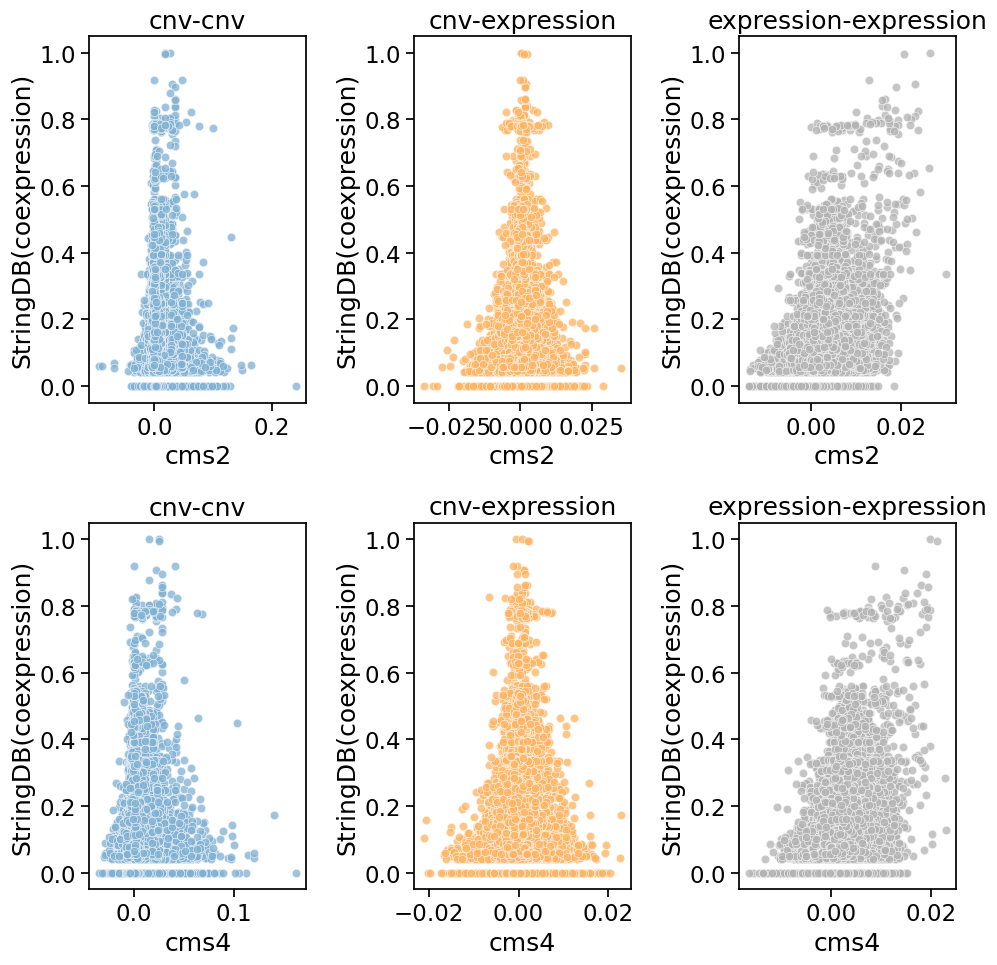

In [224]:
#f = draw_scatter_stringdb(df_dragon_stringdb.dropna(), x = ['cms1','cms2','cms3','cms4'], y = 'coexpression', savename = output_folder + 'dragon_stringdb_scatter_coexpression.pdf')
f = draw_scatter_stringdb(df_dragon_stringdb.dropna(), x = ['cms2','cms4'], y = 'coexpression', savename = None)